# DATA SCIENCE FOR BIZ - Airbnb Pricing Prediction

Claire Park, Kidae Hong, Prerna Mishra, Rahul Singh

## Business Problem

One challenge that Airbnb hosts face is determining the optimal price. In many areas, would-be renters are presented with a good selection of listings and can filter by criteria like price, number of bedrooms, room type, and more. Let’s imagine we have a room we’d like to rent on Airbnb. As hosts, if we try to charge above market price, renters will select more affordable alternatives and we won’t make any money. On the other hand, if we set our nightly rent price too low, we’ll miss out on potential revenue.

How can we hit the “sweet spot” in the middle? One strategy we could use is to:

1. Find a few listings that are similar to ours,
2. Average the listed price for the ones most similar to ours,
3. And set our listing price to this calculated average price

But doing that manually over and over again would be time-consuming, and we’re data scientists! Instead of doing it manually, we’re going to build a machine learning model using techniques such as Linear Regression and K-Nearest Neighbors (KNN).


**Question: What price should a new Airbnb host set for their hosting to get a higher score and more bookings?**




In [2328]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from pandas.plotting._misc import scatter_matrix
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#import folium
#from folium.plugins import FastMarkerCluster
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter("ignore")
plt.rcParams['figure.figsize'] = 15, 12

Importing the data and using only the relevant columns (removing all the non-essential columns)

In [2329]:
#Loading the data

url1 = 'http://data.insideairbnb.com/united-states/ny/new-york-city/2021-02-04/data/listings.csv.gz'
df = pd.read_csv(url1, header=0, index_col=0)


In [2330]:
#Printing the data
df

,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2595,https://www.airbnb.com/rooms/2595,20210204180331,2021-02-05,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,...,10.0,10.0,9.0,NaN,f,2,2,0,0,0.35
3831,https://www.airbnb.com/rooms/3831,20210204180331,2021-02-05,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,...,10.0,10.0,10.0,NaN,f,1,1,0,0,4.99
5121,https://www.airbnb.com/rooms/5121,20210204180331,2021-02-05,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,...,10.0,9.0,9.0,NaN,f,1,0,1,0,0.35
5178,https://www.airbnb.com/rooms/5178,20210204180331,2021-02-05,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,Shunichi,...,9.0,10.0,9.0,NaN,f,1,0,1,0,3.31
5203,https://www.airbnb.com/rooms/5203,20210204180331,2021-02-06,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,https://a0.muscache.com/pictures/103776/b37157...,7490,https://www.airbnb.com/users/show/7490,MaryEllen,...,10.0,10.0,10.0,NaN,f,1,0,1,0,0.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48033101,https://www.airbnb.com/rooms/48033101,20210204180331,2021-02-06,Cozy One-Bedroom with Full Kitchen Near Manhattan,NaN,NaN,https://a0.muscache.com/pictures/fe6a65ab-b670...,251455701,https://www.airbnb.com/users/show/251455701,Alexander,...,NaN,NaN,NaN,NaN,t,2,2,0,0,NaN
48033611,https://www.airbnb.com/rooms/48033611,20210204180331,2021-02-06,Grand Concourse Gem,NaN,NaN,https://a0.muscache.com/pictures/16264e28-8d24...,287782529,https://www.airbnb.com/users/show/287782529,Adriana,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
48038944,https://www.airbnb.com/rooms/48038944,20210204180331,2021-02-06,Natural Light-Filled Home in Upper East Side,"Private room with Queen bed in a 4 bedroom, 4 ...",Welcome to The Upper East Side – located north...,https://a0.muscache.com/pictures/miso/Hosting-...,305240193,https://www.airbnb.com/users/show/305240193,June,...,NaN,NaN,NaN,NaN,f,181,25,156,0,NaN


In [2331]:
#Checking for null values
df.isnull().values.any()

True

In [2332]:
#Select columns of interest
analysis = df[['neighbourhood_cleansed','neighbourhood_group_cleansed','latitude','longitude','host_is_superhost','room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'price','availability_365', 'minimum_nights', 'maximum_nights', 'review_scores_rating', 'reviews_per_month']]



In [2333]:
analysis[['beds','bedrooms']].describe()


,beds,bedrooms
count,36522.000000,33404.000000
mean,1.533925,1.316399
std,1.141557,0.722094
min,0.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,1.000000
max,42.000000,21.000000


In [2334]:
analysis.groupby("beds").mean()

,latitude,longitude,accommodates,bedrooms,availability_365,minimum_nights,maximum_nights,review_scores_rating,reviews_per_month
beds,,,,,,,,,
0.0,40.731990,-73.949604,2.447160,1.197321,165.341481,23.637671,635.365205,93.250787,0.720387
1.0,40.730961,-73.950485,1.976944,1.024866,116.527293,23.834878,96769.573493,93.871713,0.784727
2.0,40.729868,-73.954413,3.506438,1.441581,139.097672,23.082976,695.317857,93.888985,0.964832
3.0,40.723896,-73.951696,4.967754,2.106826,164.322461,21.573017,686.110452,93.544801,1.161450
4.0,40.719883,-73.947316,5.936207,2.622047,167.843966,22.019828,690.511207,93.467724,1.092067
5.0,40.717751,-73.943277,7.344473,3.002591,176.408740,19.043702,634.976864,93.240854,1.089641
6.0,40.722603,-73.941174,8.457711,3.355000,207.522388,17.557214,627.686567,94.496644,1.010397
7.0,40.708830,-73.921513,10.430233,4.000000,206.406977,14.209302,531.848837,92.521127,1.518310
8.0,40.718156,-73.927214,9.425926,4.433962,220.611111,17.462963,688.907407,93.181818,1.335455


In [2335]:
analysis.isna().sum()

neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
host_is_superhost                  18
room_type                           0
accommodates                        0
bathrooms_text                    102
bedrooms                         3608
beds                              490
price                               0
availability_365                    0
minimum_nights                      0
maximum_nights                      0
review_scores_rating            10235
reviews_per_month                9523
dtype: int64

In [2336]:
#Replace NaN to 0
#analysis = analysis.fillna(0)
analysis.bedrooms=analysis.bedrooms.fillna(round(analysis.bedrooms.mean()))
analysis.beds=analysis.beds.fillna(round(analysis.beds.mean()))
analysis.head()

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,host_is_superhost,room_type,accommodates,bathrooms_text,bedrooms,beds,price,availability_365,minimum_nights,maximum_nights,review_scores_rating,reviews_per_month
id,,,,,,,,,,,,,,,,
2595,Midtown,Manhattan,40.75362,-73.98377,f,Entire home/apt,2,1 bath,1.0,1.0,$100.00,365,30,1125,94.0,0.35
3831,Clinton Hill,Brooklyn,40.68514,-73.95976,f,Entire home/apt,3,1 bath,1.0,3.0,$73.00,249,1,730,90.0,4.99
5121,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,f,Private room,2,NaN,1.0,1.0,$60.00,365,30,730,90.0,0.35
5178,Midtown,Manhattan,40.76468,-73.98315,f,Private room,2,1 bath,1.0,1.0,$79.00,343,2,14,84.0,3.31
5203,Upper West Side,Manhattan,40.80178,-73.96723,f,Private room,1,1 shared bath,1.0,1.0,$75.00,0,2,14,98.0,0.85


In [2337]:
analysis.isna().sum()

neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
host_is_superhost                  18
room_type                           0
accommodates                        0
bathrooms_text                    102
bedrooms                            0
beds                                0
price                               0
availability_365                    0
minimum_nights                      0
maximum_nights                      0
review_scores_rating            10235
reviews_per_month                9523
dtype: int64

In [2338]:
analysis = analysis.fillna(0)

In [2339]:
analysis.isna().sum()

neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
host_is_superhost               0
room_type                       0
accommodates                    0
bathrooms_text                  0
bedrooms                        0
beds                            0
price                           0
availability_365                0
minimum_nights                  0
maximum_nights                  0
review_scores_rating            0
reviews_per_month               0
dtype: int64

In [2340]:
analysis.describe()


,latitude,longitude,accommodates,bedrooms,beds,availability_365,minimum_nights,maximum_nights,review_scores_rating,reviews_per_month
count,37012.000000,37012.000000,37012.000000,37012.000000,37012.000000,37012.000000,37012.000000,3.701200e+04,37012.000000,37012.000000
mean,40.729653,-73.950989,2.797633,1.285556,1.540095,130.282800,23.323679,5.979924e+04,67.837566,0.644072
std,0.054710,0.048291,1.845570,0.692385,1.135226,146.635272,26.441255,1.116338e+07,42.727598,1.199490
min,40.508680,-74.239860,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000
25%,40.690320,-73.983812,2.000000,1.000000,1.000000,0.000000,4.000000,9.000000e+01,0.000000,0.000000
50%,40.725465,-73.955790,2.000000,1.000000,1.000000,66.000000,30.000000,1.125000e+03,93.000000,0.160000
75%,40.762480,-73.933720,4.000000,1.000000,2.000000,292.000000,30.000000,1.125000e+03,99.000000,0.770000
max,40.912140,-73.710870,16.000000,21.000000,42.000000,365.000000,1250.000000,2.147484e+09,100.000000,40.310000


In [2341]:
analysis.shape

(37012, 16)

In [2342]:
analysis.dtypes

neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
host_is_superhost                object
room_type                        object
accommodates                      int64
bathrooms_text                   object
bedrooms                        float64
beds                            float64
price                            object
availability_365                  int64
minimum_nights                    int64
maximum_nights                    int64
review_scores_rating            float64
reviews_per_month               float64
dtype: object

In [2343]:
#Create a new varialbe to show popularity of each listing
analysis['popularity'] = analysis['review_scores_rating'] * analysis['reviews_per_month']

analysis = analysis.sort_values(by=['popularity'], ascending=False)
analysis.head()

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,host_is_superhost,room_type,accommodates,bathrooms_text,bedrooms,beds,price,availability_365,minimum_nights,maximum_nights,review_scores_rating,reviews_per_month,popularity
id,,,,,,,,,,,,,,,,,
34071682,SoHo,Manhattan,40.72440,-74.00794,f,Hotel room,2,1 bath,1.0,1.0,$63.00,0,1,28,91.0,40.31,3668.21
44799007,Financial District,Manhattan,40.70603,-74.01538,f,Entire home/apt,2,1 bath,1.0,1.0,$136.00,360,2,365,94.0,39.02,3667.88
32678719,Theater District,Manhattan,40.75876,-73.98846,f,Hotel room,2,1 bath,1.0,1.0,$77.00,310,1,1125,85.0,34.33,2918.05
34072045,Midtown,Manhattan,40.74623,-73.98499,f,Hotel room,2,1 bath,1.0,1.0,$79.00,78,1,28,91.0,30.82,2804.62
34072049,Midtown,Manhattan,40.74623,-73.98499,f,Hotel room,2,1 bath,1.0,1.0,$79.00,45,1,28,91.0,23.34,2123.94


In [2344]:
analysis.describe()

,latitude,longitude,accommodates,bedrooms,beds,availability_365,minimum_nights,maximum_nights,review_scores_rating,reviews_per_month,popularity
count,37012.000000,37012.000000,37012.000000,37012.000000,37012.000000,37012.000000,37012.000000,3.701200e+04,37012.000000,37012.000000,37012.000000
mean,40.729653,-73.950989,2.797633,1.285556,1.540095,130.282800,23.323679,5.979924e+04,67.837566,0.644072,60.700160
std,0.054710,0.048291,1.845570,0.692385,1.135226,146.635272,26.441255,1.116338e+07,42.727598,1.199490,112.600941
min,40.508680,-74.239860,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000
25%,40.690320,-73.983812,2.000000,1.000000,1.000000,0.000000,4.000000,9.000000e+01,0.000000,0.000000,0.000000
50%,40.725465,-73.955790,2.000000,1.000000,1.000000,66.000000,30.000000,1.125000e+03,93.000000,0.160000,15.000000
75%,40.762480,-73.933720,4.000000,1.000000,2.000000,292.000000,30.000000,1.125000e+03,99.000000,0.770000,72.380000
max,40.912140,-73.710870,16.000000,21.000000,42.000000,365.000000,1250.000000,2.147484e+09,100.000000,40.310000,3668.210000


In [2345]:
#analysis['neighbourhood_group_cleansed'] = analysis['neighbourhood_group_cleansed'].astype('category')
#analysis['room_type'] = analysis['room_type'].astype('category')
#analysis['host_acceptance_rate'] =analysis['host_acceptance_rate'].astype(str)
#analysis['host_acceptance_rate'] = analysis['host_acceptance_rate'].str.replace('%', '')
#analysis['host_acceptance_rate'] = analysis['host_acceptance_rate'].astype(int)
analysis['host_is_superhost'] =analysis['host_is_superhost'].astype(str)
analysis['host_is_superhost'] = analysis['host_is_superhost'].str.replace('t', '1')
analysis['host_is_superhost'] = analysis['host_is_superhost'].str.replace('f', '0')
analysis['host_is_superhost'] = analysis['host_is_superhost'].astype(int)
analysis['price'] =analysis['price'].astype(str)
analysis['price'] = analysis['price'].str.replace(',', '')
analysis['price'] = analysis['price'].str.replace('$', '')
analysis['price'] = analysis['price'].astype(float)
analysis.dtypes

neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
host_is_superhost                 int64
room_type                        object
accommodates                      int64
bathrooms_text                   object
bedrooms                        float64
beds                            float64
price                           float64
availability_365                  int64
minimum_nights                    int64
maximum_nights                    int64
review_scores_rating            float64
reviews_per_month               float64
popularity                      float64
dtype: object

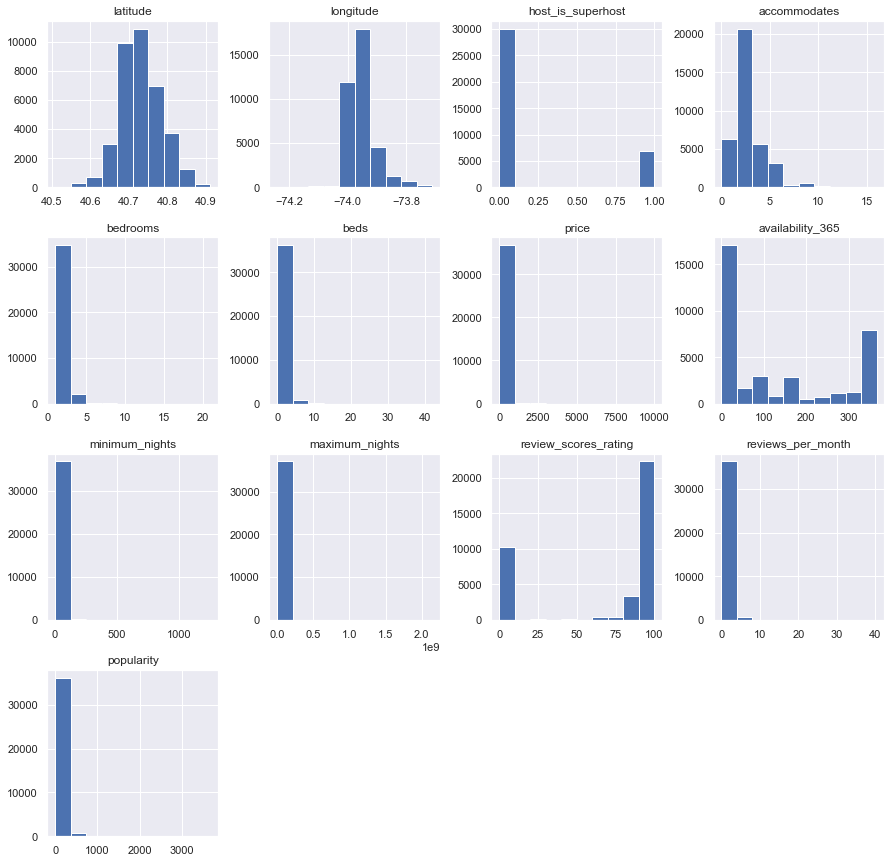

In [2346]:
fig, ax = plt.subplots(figsize=(15, 15))
analysis.hist(ax=ax)
plt.show()

In [2347]:
from pandas.plotting._misc import scatter_matrix
columns_taken=['price','neighbourhood_group_cleansed','room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds','availability_365', 'minimum_nights', 'maximum_nights', 'review_scores_rating', 'reviews_per_month','popularity']

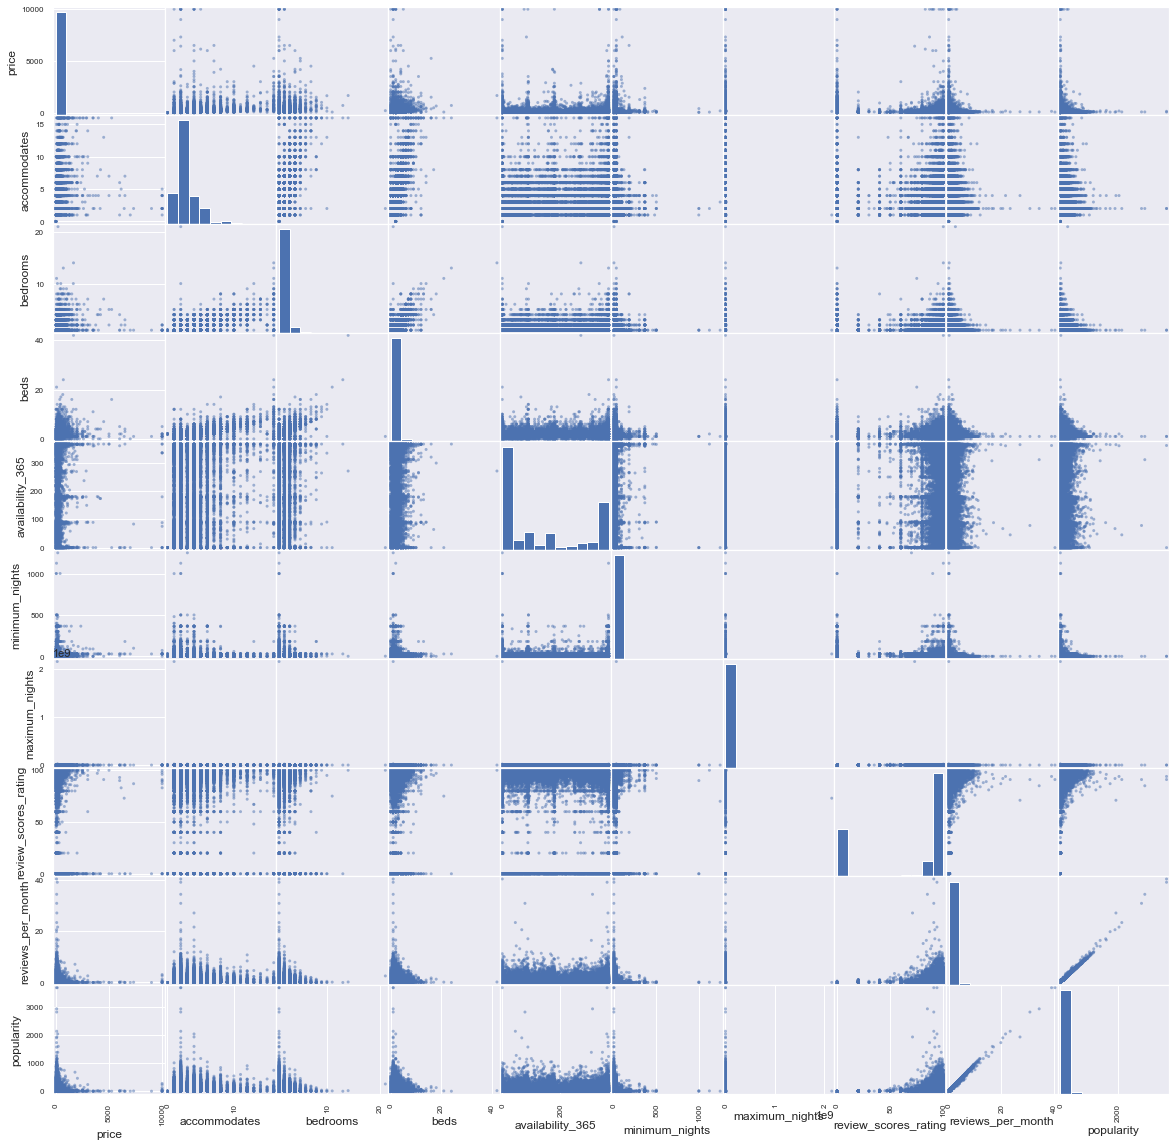

In [2348]:
scatter_plots = scatter_matrix(analysis[columns_taken],figsize=(20,20))

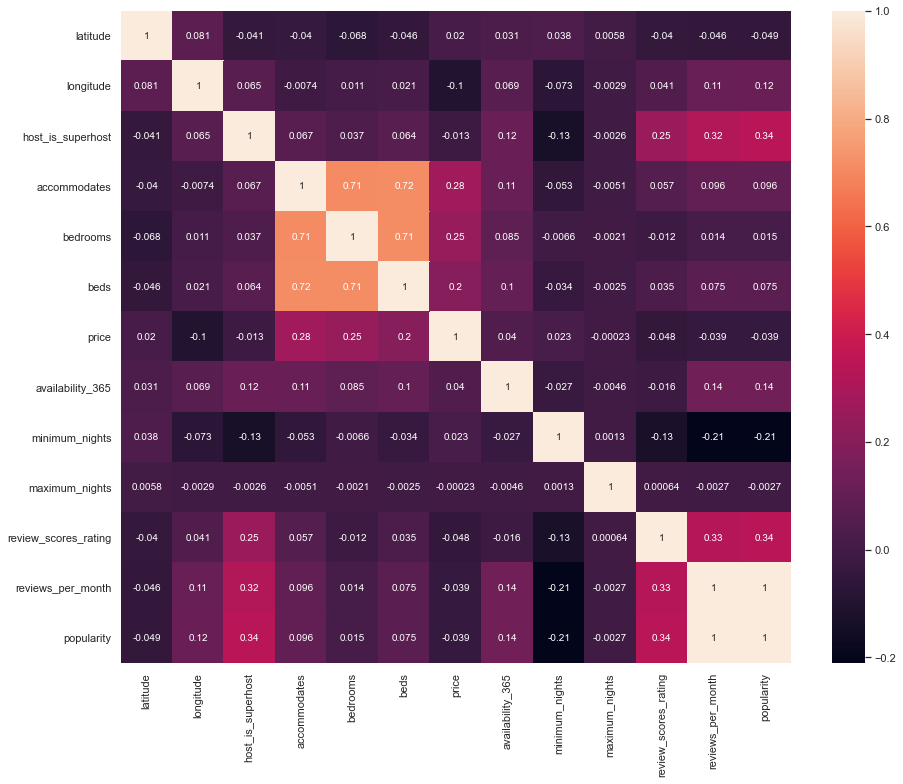

In [2349]:
correlation_mat = analysis.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

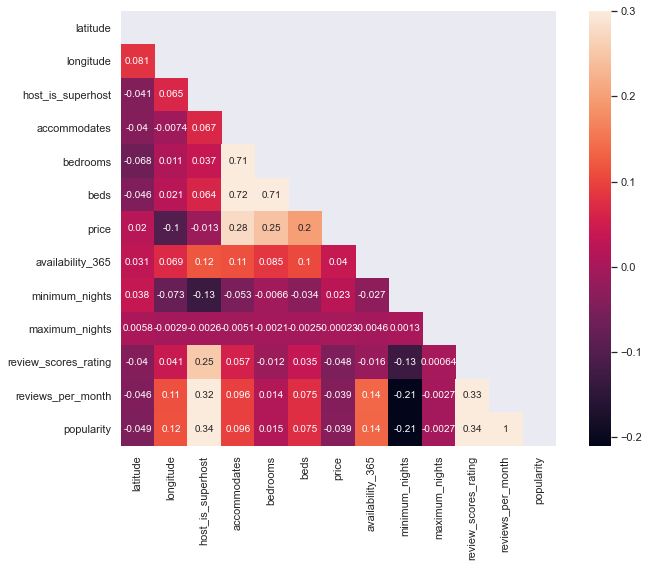

In [2350]:

corr = analysis.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

In [2351]:
a = analysis.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=True).head(20)
d = analysis.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).head(20)

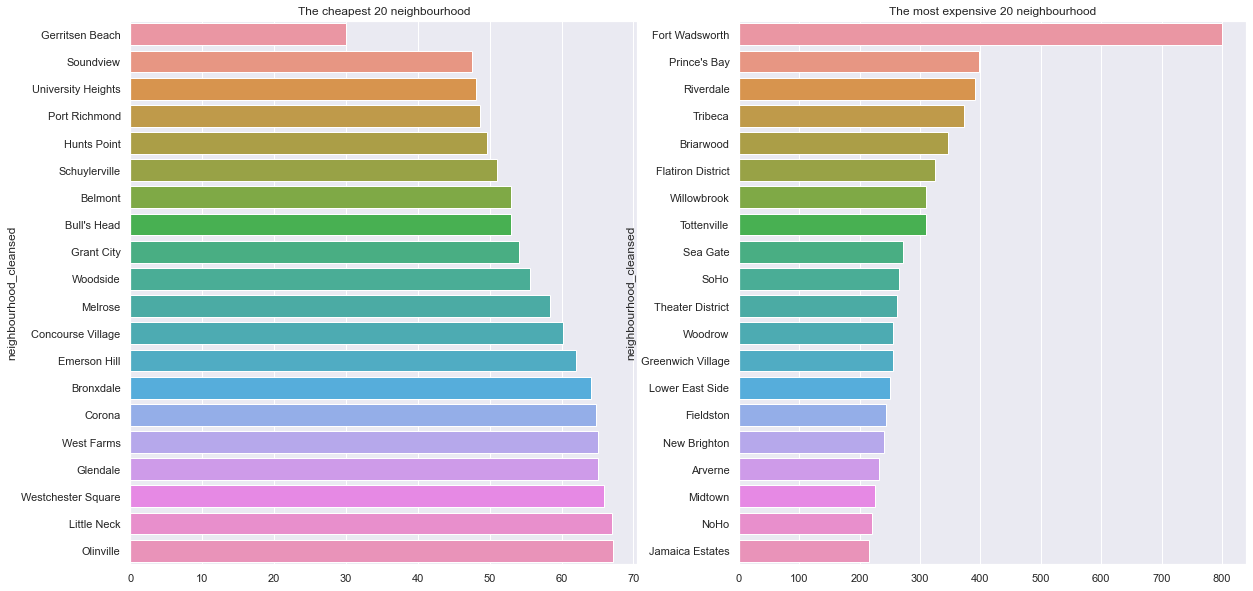

In [2352]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(121)
sns.barplot(y=a.index, x=a.values, ax=ax1)
ax1.set_title('The cheapest 20 neighbourhood')

ax2 = fig.add_subplot(122)
sns.barplot(y=d.index, x=d.values, ax=ax2)
ax2.set_title('The most expensive 20 neighbourhood')
plt.show()

In [2353]:
a = analysis.groupby(['neighbourhood_group_cleansed', 'neighbourhood_cleansed'])['price'].mean().sort_values(ascending=False).head(50)
a = a.reset_index()
a

,neighbourhood_group_cleansed,neighbourhood_cleansed,price
0,Staten Island,Fort Wadsworth,800.000000
1,Staten Island,Prince's Bay,397.500000
2,Bronx,Riverdale,391.375000
3,Manhattan,Tribeca,373.203593
4,Queens,Briarwood,346.147059
5,Manhattan,Flatiron District,324.173333
6,Staten Island,Tottenville,309.000000
7,Staten Island,Willowbrook,309.000000
8,Brooklyn,Sea Gate,270.909091
9,Manhattan,SoHo,265.854610


[]

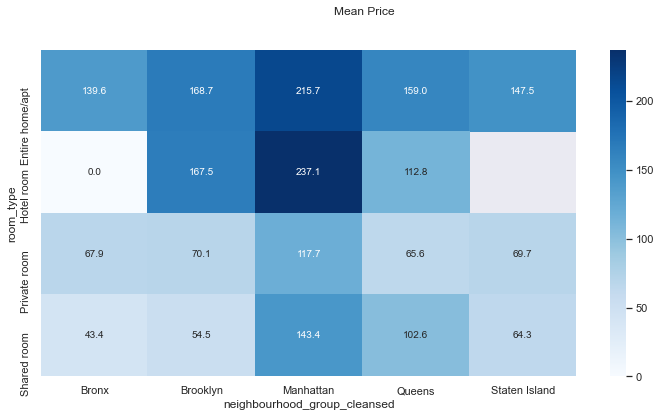

In [2354]:
plt.figure(figsize=(12, 6))
df_pivot = analysis.pivot_table(values='price', index='room_type', columns='neighbourhood_group_cleansed', aggfunc='mean')
sns.heatmap(df_pivot, annot=True, fmt='.1f', cmap='Blues')
plt.suptitle('Mean Price')
plt.plot()

In [2355]:
analysis_pop = analysis[analysis['popularity']>0]
analysis_pop[['popularity']].describe()

,popularity
count,26777.000000
mean,83.901644
std,124.814799
min,0.200000
25%,11.000000
50%,35.280000
75%,109.610000
max,3668.210000


In [2442]:
#Make a subgroup with Top 25% popularity score
top25_pop = analysis[analysis['popularity']>100]
top25_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7199 entries, 34071682 to 37806107
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_cleansed        7199 non-null   object 
 1   neighbourhood_group_cleansed  7199 non-null   object 
 2   latitude                      7199 non-null   float64
 3   longitude                     7199 non-null   float64
 4   host_is_superhost             7199 non-null   int64  
 5   room_type                     7199 non-null   object 
 6   accommodates                  7199 non-null   int64  
 7   bathrooms_text                7199 non-null   object 
 8   bedrooms                      7199 non-null   float64
 9   beds                          7199 non-null   float64
 10  price                         7199 non-null   float64
 11  availability_365              7199 non-null   int64  
 12  minimum_nights                7199 non-null   int64

In [2443]:
top25_pop[['neighbourhood_cleansed','neighbourhood_group_cleansed','room_type', 'bathrooms_text']].describe()

,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,bathrooms_text
count,7199,7199,7199,7199
unique,202,5,4,23
top,Bedford-Stuyvesant,Brooklyn,Entire home/apt,1 bath
freq,683,2940,3882,3541


In [2444]:
top25_pop['bathrooms_text'].unique()

array(['1 bath', '1 private bath', '1 shared bath', '3 baths',
       '1.5 shared baths', '2 shared baths', '0 shared baths', '2 baths',
       '1.5 baths', 'Half-bath', '2.5 baths', '4.5 baths', 0, '5.5 baths',
       '3 shared baths', 'Shared half-bath', '4 shared baths',
       '3.5 baths', '4 baths', '0 baths', '2.5 shared baths', '5 baths',
       'Private half-bath'], dtype=object)

In [2445]:
#Make a new column for the number of bathroom and whether it is shared or not
half_bath = ['Half-bath', 'Shared half-bath', 'Private half-bath']
top25_pop["bathrooms"] = top25_pop["bathrooms_text"].str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
top25_pop["bathrooms"] = np.where(top25_pop["bathrooms_text"].isin(half_bath), 0.5, top25_pop["bathrooms"])

top25_pop["bathrooms_share"] = np.where(top25_pop["bathrooms_text"].str.contains('shared|Shared'), 1, 0)
top25_pop["bathrooms_share"] = np.where(top25_pop["bathrooms_text"].str.contains('0'), 0, top25_pop['bathrooms_share'])


In [2446]:
top25_pop = top25_pop.fillna(0)
top25_pop.dtypes

neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
host_is_superhost                 int64
room_type                        object
accommodates                      int64
bathrooms_text                   object
bedrooms                        float64
beds                            float64
price                           float64
availability_365                  int64
minimum_nights                    int64
maximum_nights                    int64
review_scores_rating            float64
reviews_per_month               float64
popularity                      float64
bathrooms                       float64
bathrooms_share                   int64
dtype: object

In [2447]:
top25_pop.sort_values(by=['bathrooms']).head(10)

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,host_is_superhost,room_type,accommodates,bathrooms_text,bedrooms,beds,price,availability_365,minimum_nights,maximum_nights,review_scores_rating,reviews_per_month,popularity,bathrooms,bathrooms_share
id,,,,,,,,,,,,,,,,,,,
1777007,Battery Park City,Manhattan,40.71098,-74.01616,0,Shared room,1,0,1.0,1.0,37.0,365,1,1125,93.0,2.63,244.59,0.0,0
33055126,Hell's Kitchen,Manhattan,40.76088,-73.98806,0,Entire home/apt,2,0 baths,1.0,0.0,52.0,303,20,1125,92.0,2.19,201.48,0.0,0
1215627,Arverne,Queens,40.59204,-73.78665,1,Entire home/apt,2,0 baths,1.0,0.0,157.0,311,1,1125,96.0,1.69,162.24,0.0,0
14761949,Harlem,Manhattan,40.82412,-73.95449,0,Private room,2,0 shared baths,1.0,1.0,89.0,0,30,1125,96.0,2.23,214.08,0.0,0
46548649,Crown Heights,Brooklyn,40.67160,-73.92148,0,Private room,3,0,1.0,2.0,60.0,360,1,21,91.0,3.65,332.15,0.0,0
41897797,Ozone Park,Queens,40.67662,-73.85223,0,Shared room,2,0 shared baths,1.0,2.0,86.0,342,3,28,100.0,1.71,171.00,0.0,0
938022,Williamsburg,Brooklyn,40.70780,-73.94827,0,Private room,2,0,1.0,1.0,58.0,364,1,150,97.0,1.07,103.79,0.0,0
571564,Crown Heights,Brooklyn,40.67436,-73.94807,0,Private room,2,0,1.0,1.0,95.0,365,30,365,90.0,1.22,109.80,0.0,0
30003335,West Brighton,Staten Island,40.63059,-74.11465,1,Private room,2,0 shared baths,1.0,1.0,60.0,365,30,180,99.0,1.16,114.84,0.0,0


In [2448]:
new_pop = top25_pop[['host_is_superhost','latitude','longitude','neighbourhood_cleansed','neighbourhood_group_cleansed','room_type', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights','availability_365','review_scores_rating', 'reviews_per_month', 'bathrooms', 'bathrooms_share','popularity', 'price']]
new_pop.head(5)
new_pop['neighbourhood_group_cleansed'].unique()


array(['Manhattan', 'Queens', 'Bronx', 'Brooklyn', 'Staten Island'],
      dtype=object)

In [2449]:
new_pop.describe()

,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,review_scores_rating,reviews_per_month,bathrooms,bathrooms_share,popularity,price
count,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000,7199.000000
mean,0.478539,40.724603,-73.939030,3.265870,1.342548,1.789276,12.228365,566.093207,172.506320,94.874010,2.462403,1.130921,0.328240,233.016877,123.238089
std,0.499574,0.060175,0.060227,2.115685,0.737711,1.285314,16.725056,521.174440,139.268865,4.617439,1.727354,0.395227,0.469605,159.958934,236.112550
min,0.000000,40.540030,-74.208820,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,54.000000,1.010000,0.000000,0.000000,100.050000,10.000000
25%,0.000000,40.682905,-73.981585,2.000000,1.000000,1.000000,2.000000,30.000000,36.000000,93.000000,1.470000,1.000000,0.000000,138.180000,60.000000
50%,0.000000,40.717720,-73.947850,2.000000,1.000000,1.000000,3.000000,365.000000,160.000000,96.000000,2.050000,1.000000,0.000000,195.300000,91.000000
75%,1.000000,40.761515,-73.917810,4.000000,1.000000,2.000000,30.000000,1125.000000,333.000000,98.000000,2.890000,1.000000,1.000000,273.510000,140.000000
max,1.000000,40.910780,-73.722350,16.000000,21.000000,18.000000,365.000000,1125.000000,365.000000,100.000000,40.310000,5.500000,1.000000,3668.210000,9999.000000


In [2450]:
new_pop['room_type'].unique()

array(['Hotel room', 'Entire home/apt', 'Private room', 'Shared room'],
      dtype=object)

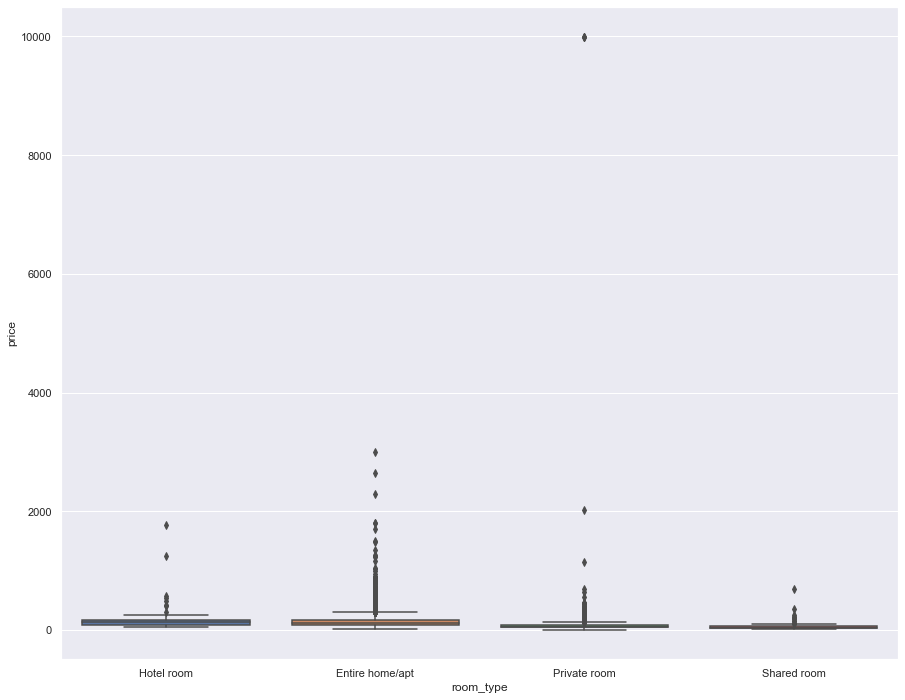

In [2451]:
sns.boxplot(data=new_pop, y='price', x='room_type', orient='v')
plt.show()

In [2452]:
print('Non available accommodation: ',
      new_pop.loc[new_pop['availability_365'] == 0].shape[0])

Non available accommodation:  1256


minimum_nights max value  1250
minimum_nights min value  1


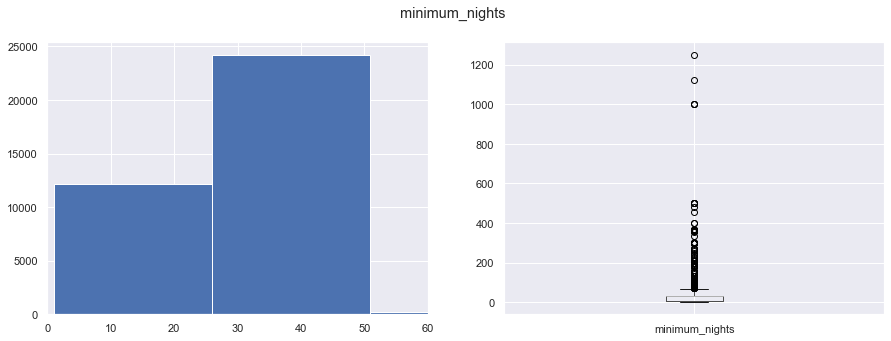

In [2453]:
print('minimum_nights max value ', df['minimum_nights'].max())
print('minimum_nights min value ', df['minimum_nights'].min())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df['minimum_nights'].hist(ax=ax[0], bins=50)
df.boxplot('minimum_nights', ax=ax[1])
fig.suptitle('minimum_nights')
ax[0].set_xlim(0, 60)
plt.show()

In [2454]:
new_pop = new_pop.loc[new_pop['minimum_nights'] <= 50]
new_pop.reset_index(drop=True, inplace=True)

In [2455]:
new_pop.describe()

,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,review_scores_rating,reviews_per_month,bathrooms,bathrooms_share,popularity,price
count,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000
mean,0.478564,40.724636,-73.939024,3.266304,1.342829,1.789136,11.620444,566.203603,172.512219,94.869013,2.463891,1.131476,0.329144,233.141011,123.279849
std,0.499575,0.060254,0.060338,2.117668,0.738918,1.287325,13.077852,521.664843,139.146250,4.623917,1.730414,0.396029,0.469935,160.225697,236.685749
min,0.000000,40.540030,-74.208820,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,54.000000,1.010000,0.000000,0.000000,100.050000,10.000000
25%,0.000000,40.682870,-73.981610,2.000000,1.000000,1.000000,2.000000,30.000000,36.000000,93.000000,1.470000,1.000000,0.000000,138.180000,60.000000
50%,0.000000,40.717840,-73.947900,2.000000,1.000000,1.000000,3.000000,365.000000,160.000000,96.000000,2.050000,1.000000,0.000000,195.300000,91.000000
75%,1.000000,40.761540,-73.917720,4.000000,1.000000,2.000000,30.000000,1125.000000,333.000000,98.000000,2.890000,1.000000,1.000000,273.600000,139.000000
max,1.000000,40.910780,-73.722350,16.000000,21.000000,18.000000,45.000000,1125.000000,365.000000,100.000000,40.310000,5.500000,1.000000,3668.210000,9999.000000


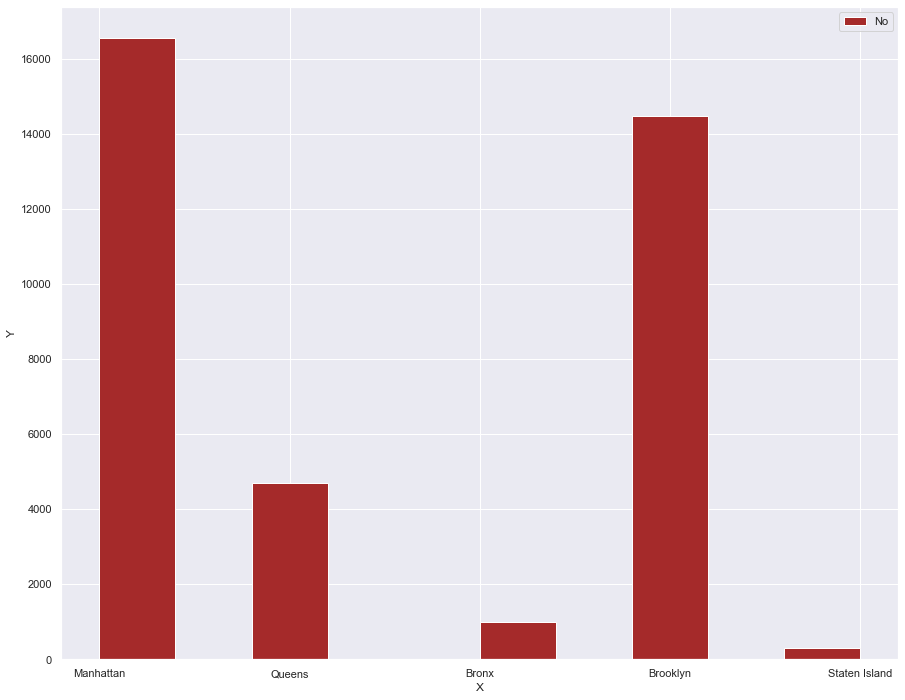

In [2456]:
#sns
sns.set() 
plt.hist(analysis['neighbourhood_group_cleansed'], color='brown', label='No')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend() 
plt.show()

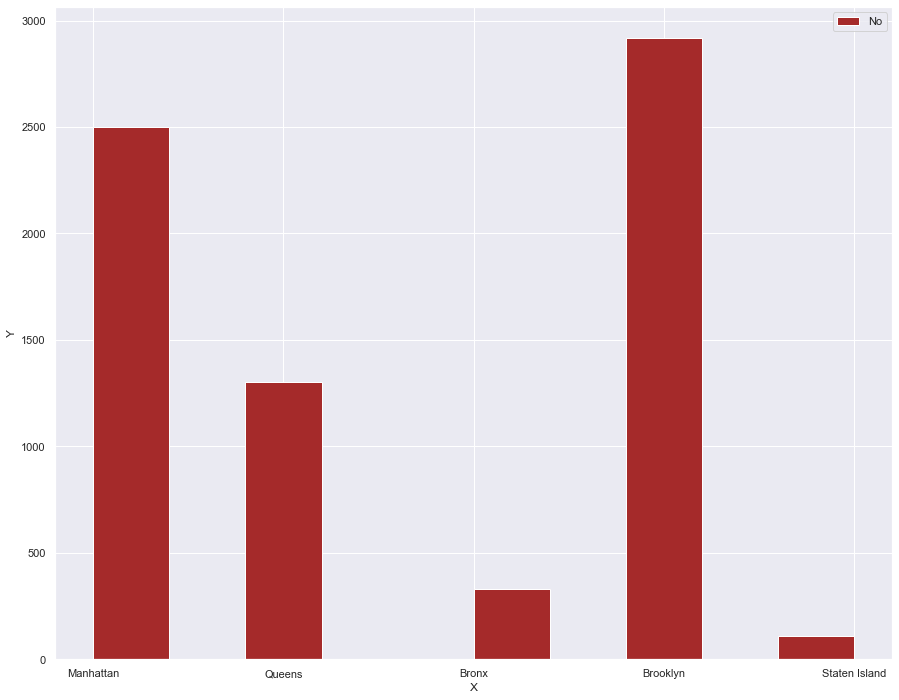

In [2457]:
#sns
sns.set() 
plt.hist(new_pop['neighbourhood_group_cleansed'], color='brown', label='No')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend() 
plt.show()

Text(0.5, 1.0, 'Numbers in Each Neigbourhoods')

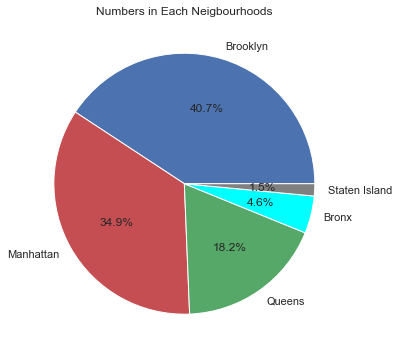

In [2458]:
plt.figure(figsize=(6,6))
numbers = new_pop['neighbourhood_group_cleansed'].value_counts()
plt.pie(numbers.values, labels=numbers.index, colors=['b', 'r', 'g', 'cyan', 'gray'], autopct='%1.1f%%')
plt.title('Numbers in Each Neigbourhoods')

In [2459]:
new_pop['neighbourhood_cleansed'] = new_pop['neighbourhood_cleansed'].astype('category')
new_pop['room_type'] = new_pop['room_type'].astype('category')
new_pop['neighbourhood_group_cleansed'] = new_pop['neighbourhood_group_cleansed'].astype('category')
new_pop['room_type'] = new_pop['room_type'].astype('category')
new_pop['price'] = new_pop['price'].astype(str)
new_pop['price'] = new_pop['price'].str.replace(',', '')
new_pop['price'] = new_pop['price'].str.replace('$', '')
new_pop['price'] = new_pop['price'].astype(float)
new_pop.dtypes 

host_is_superhost                  int64
latitude                         float64
longitude                        float64
neighbourhood_cleansed          category
neighbourhood_group_cleansed    category
room_type                       category
accommodates                       int64
bedrooms                         float64
beds                             float64
minimum_nights                     int64
maximum_nights                     int64
availability_365                   int64
review_scores_rating             float64
reviews_per_month                float64
bathrooms                        float64
bathrooms_share                    int64
popularity                       float64
price                            float64
dtype: object

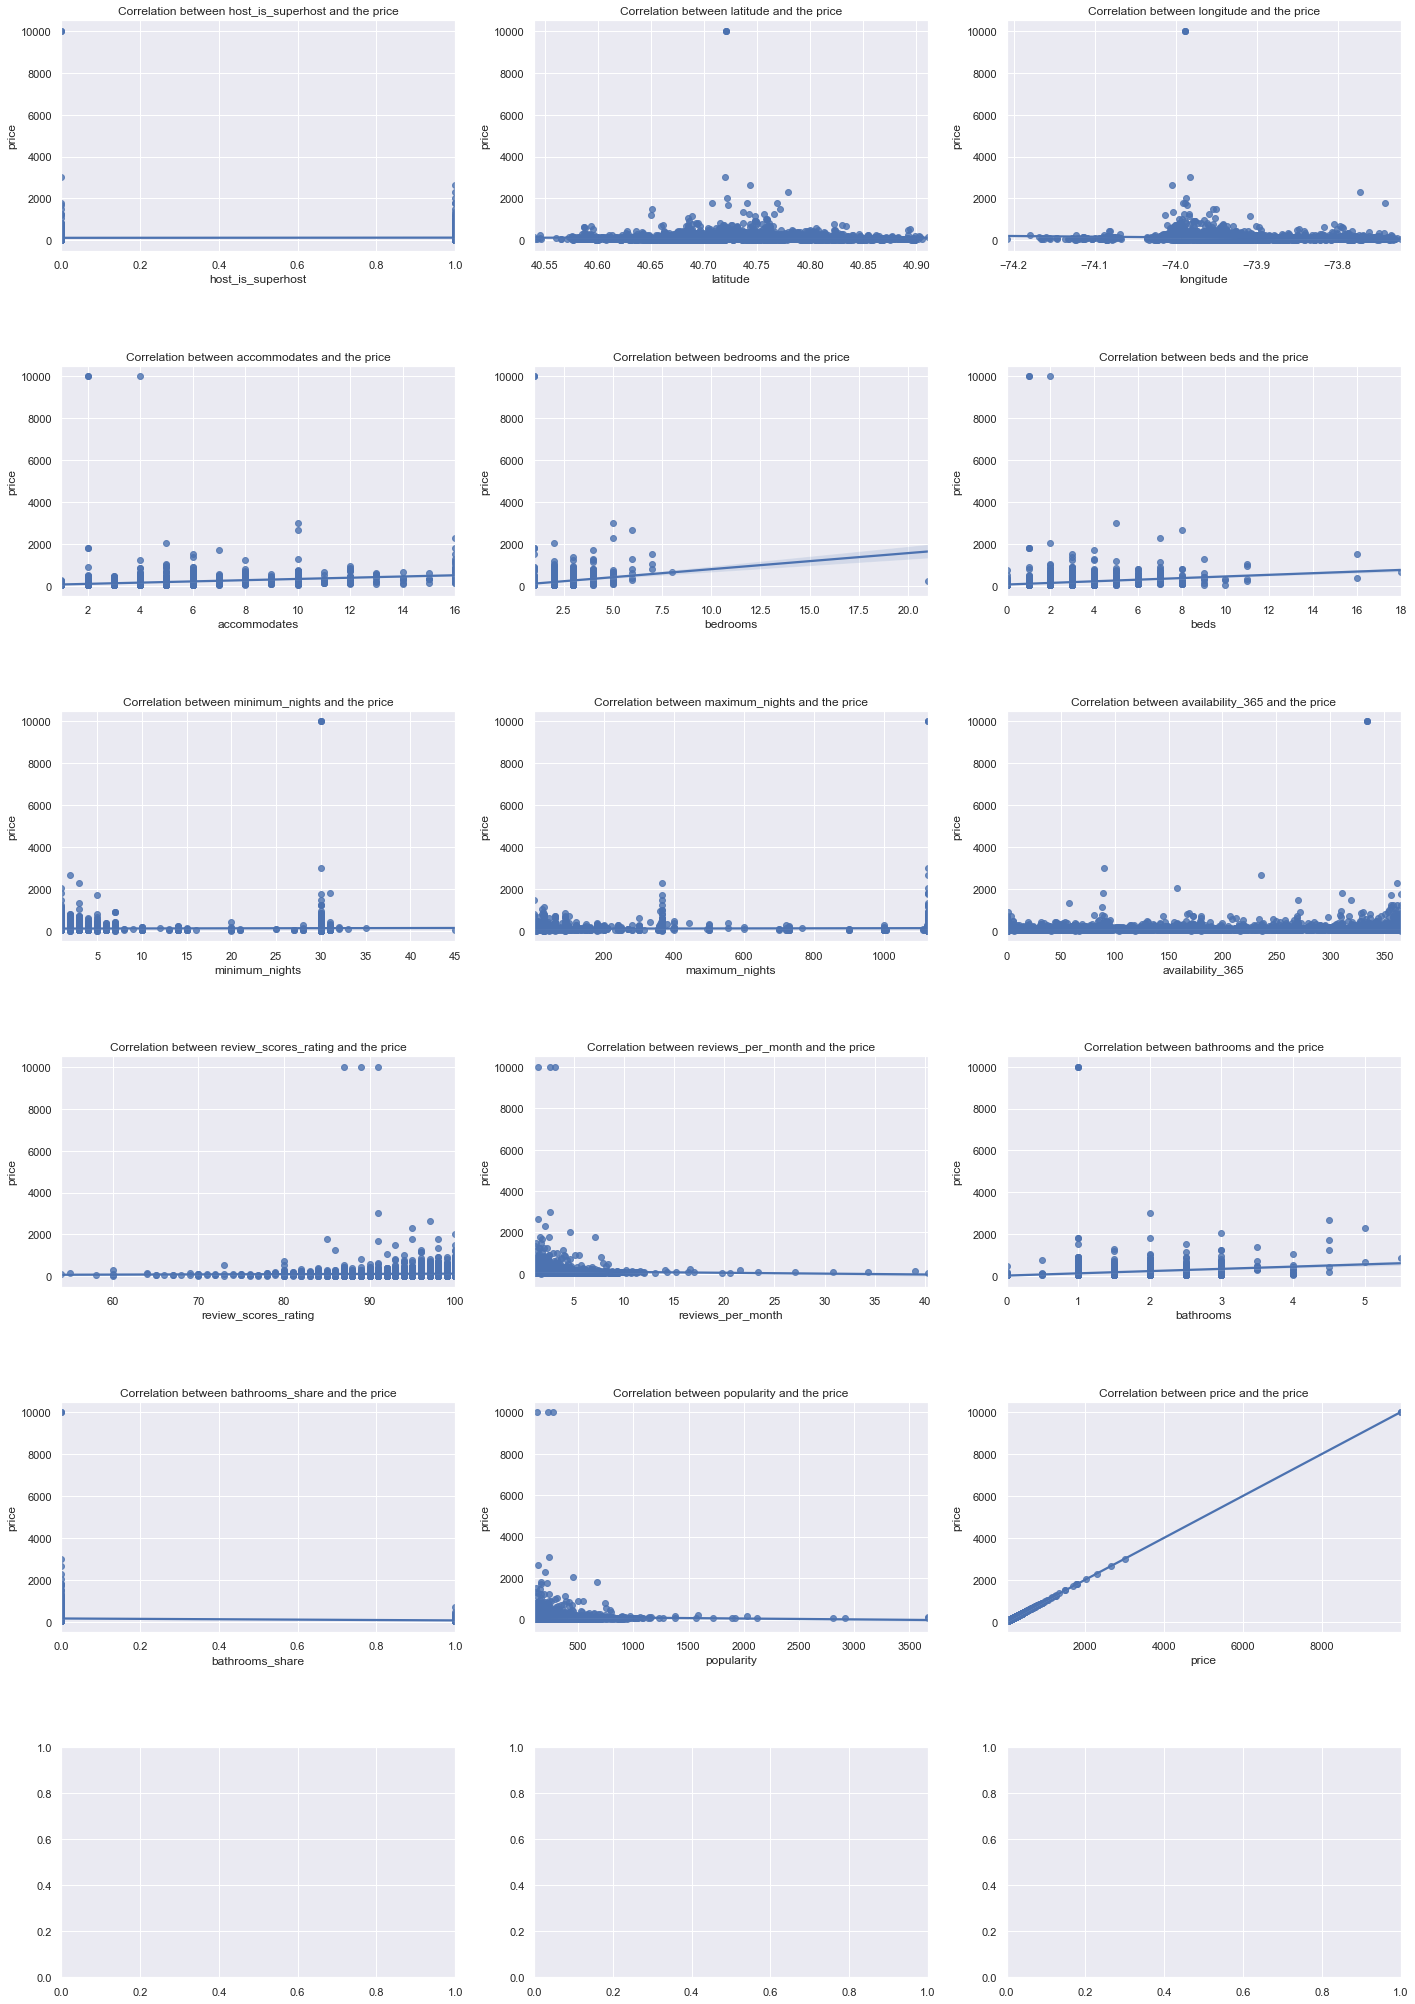

In [2460]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = new_pop.select_dtypes(include=numerics)
nrows = int(len(newdf.columns) / 3) + 1
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(24, 6*nrows))
fig.subplots_adjust(hspace=0.5)

for ax, name in zip(axes.flatten(), newdf.columns):
  
  sns.regplot(x=name, y='price', data=newdf, ax=ax)
  ax.set_title(f"Correlation between {name} and the price")

plt.show()

In [2461]:
new_pop.describe()

,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,review_scores_rating,reviews_per_month,bathrooms,bathrooms_share,popularity,price
count,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000
mean,0.478564,40.724636,-73.939024,3.266304,1.342829,1.789136,11.620444,566.203603,172.512219,94.869013,2.463891,1.131476,0.329144,233.141011,123.279849
std,0.499575,0.060254,0.060338,2.117668,0.738918,1.287325,13.077852,521.664843,139.146250,4.623917,1.730414,0.396029,0.469935,160.225697,236.685749
min,0.000000,40.540030,-74.208820,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,54.000000,1.010000,0.000000,0.000000,100.050000,10.000000
25%,0.000000,40.682870,-73.981610,2.000000,1.000000,1.000000,2.000000,30.000000,36.000000,93.000000,1.470000,1.000000,0.000000,138.180000,60.000000
50%,0.000000,40.717840,-73.947900,2.000000,1.000000,1.000000,3.000000,365.000000,160.000000,96.000000,2.050000,1.000000,0.000000,195.300000,91.000000
75%,1.000000,40.761540,-73.917720,4.000000,1.000000,2.000000,30.000000,1125.000000,333.000000,98.000000,2.890000,1.000000,1.000000,273.600000,139.000000
max,1.000000,40.910780,-73.722350,16.000000,21.000000,18.000000,45.000000,1125.000000,365.000000,100.000000,40.310000,5.500000,1.000000,3668.210000,9999.000000


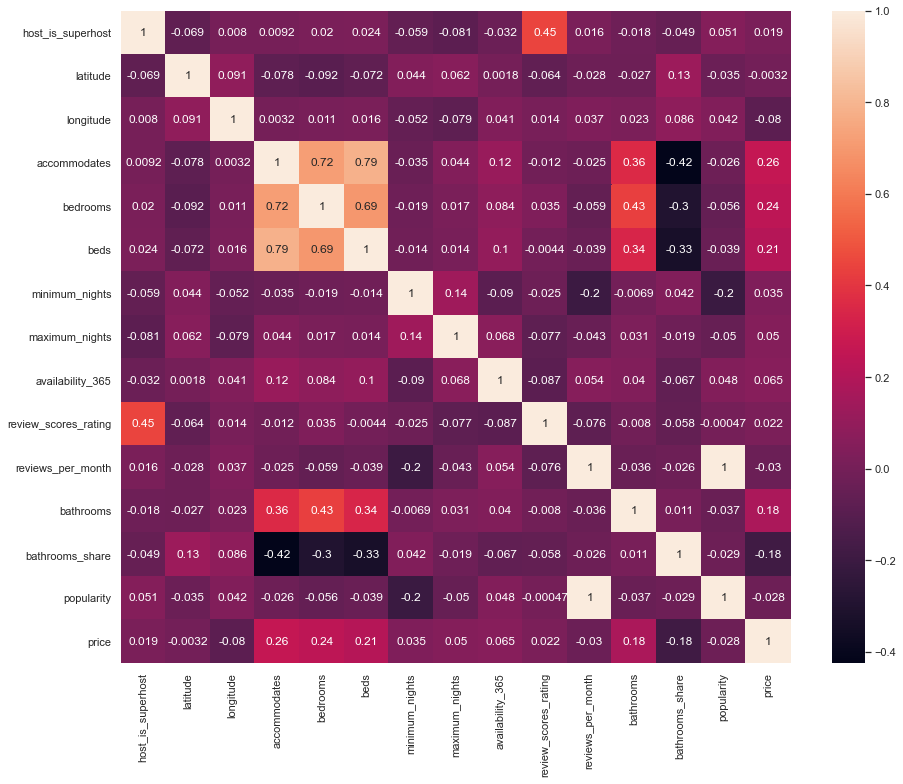

In [2462]:
correlation_mat = new_pop.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

In [2463]:
new_pop.info

<bound method DataFrame.info of       host_is_superhost  latitude  longitude neighbourhood_cleansed  \
0                     0  40.72440  -74.00794                   SoHo   
1                     0  40.70603  -74.01538     Financial District   
2                     0  40.75876  -73.98846       Theater District   
3                     0  40.74623  -73.98499                Midtown   
4                     0  40.74623  -73.98499                Midtown   
...                 ...       ...        ...                    ...   
7156                  0  40.86841  -73.85032               Allerton   
7157                  0  40.67342  -73.78380                Jamaica   
7158                  0  40.74137  -73.98432      Flatiron District   
7159                  0  40.68984  -73.95194     Bedford-Stuyvesant   
7160                  0  40.79556  -73.97426        Upper West Side   

     neighbourhood_group_cleansed        room_type  accommodates  bedrooms  \
0                       Manhattan    

In [2464]:
new_pop.groupby("neighbourhood_group_cleansed")["price"].mean()

neighbourhood_group_cleansed
Bronx             83.177711
Brooklyn         113.199794
Manhattan        155.745898
Queens            95.575153
Staten Island    102.185185
Name: price, dtype: float64

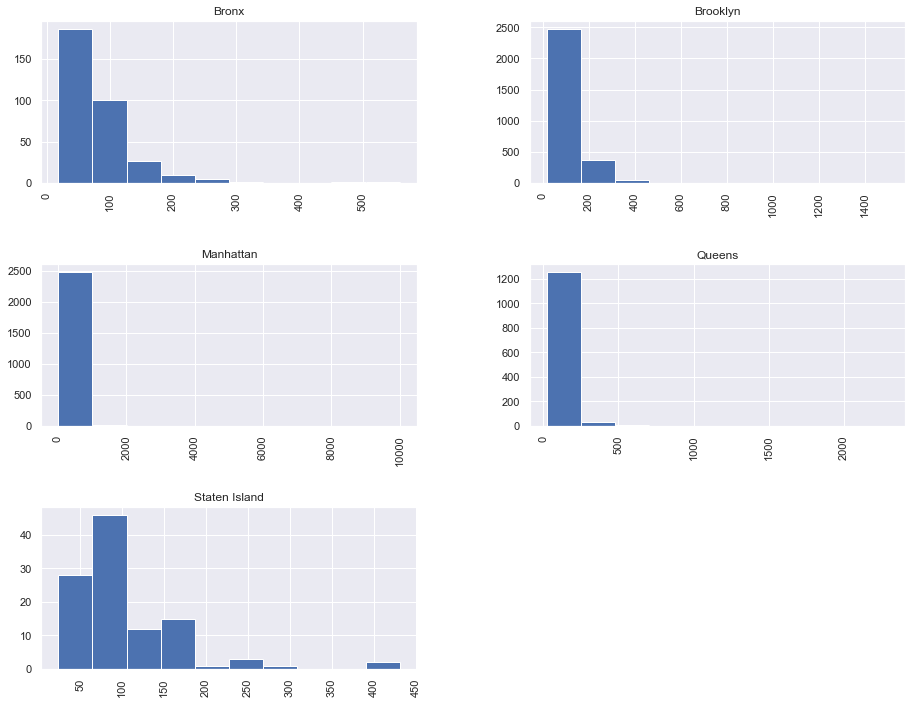

In [2465]:
#Plotting histograms for
new_pop.hist(by='neighbourhood_group_cleansed',column='price')
plt.show()

<AxesSubplot:>

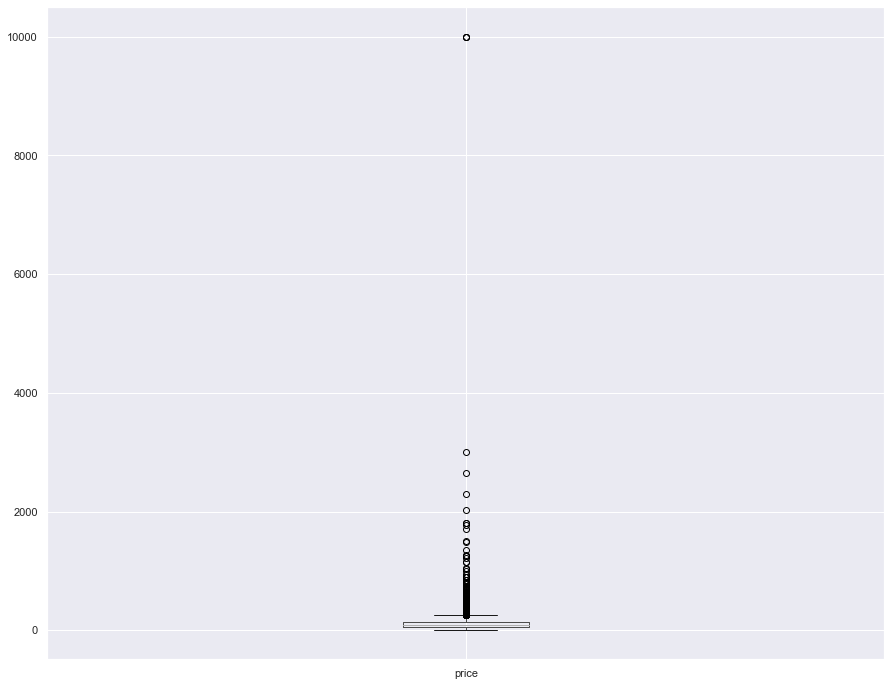

In [2466]:
new_pop.boxplot(column="price")

In [2467]:
new_pop["price"].skew()

31.592280824530363

In [2468]:
new_pop["price"].quantile(0.995)

799.1999999999998

In [2469]:
new_pop = new_pop[new_pop["price"]<new_pop["price"].quantile(0.995)].reset_index(drop=True)

In [2470]:
new_pop["price"].skew()

2.9333352890926525

In [2471]:
new_pop.describe()

,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,review_scores_rating,reviews_per_month,bathrooms,bathrooms_share,popularity,price
count,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000
mean,0.477895,40.724593,-73.938885,3.237895,1.334175,1.775579,11.616140,565.201123,171.909754,94.865684,2.463556,1.125474,0.330807,233.094408,113.657825
std,0.499546,0.060351,0.060335,2.050040,0.718658,1.253303,13.076359,521.750231,139.040534,4.624691,1.732081,0.377056,0.470537,160.350159,85.409763
min,0.000000,40.540030,-74.208820,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,54.000000,1.010000,0.000000,0.000000,100.050000,10.000000
25%,0.000000,40.682820,-73.981390,2.000000,1.000000,1.000000,2.000000,30.000000,36.000000,93.000000,1.470000,1.000000,0.000000,138.180000,60.000000
50%,0.000000,40.717610,-73.947750,2.000000,1.000000,1.000000,3.000000,365.000000,158.000000,96.000000,2.050000,1.000000,0.000000,195.300000,90.000000
75%,1.000000,40.761620,-73.917620,4.000000,1.000000,2.000000,30.000000,1125.000000,332.000000,98.000000,2.890000,1.000000,1.000000,273.540000,139.000000
max,1.000000,40.910780,-73.722350,16.000000,21.000000,18.000000,45.000000,1125.000000,365.000000,100.000000,40.310000,5.000000,1.000000,3668.210000,799.000000


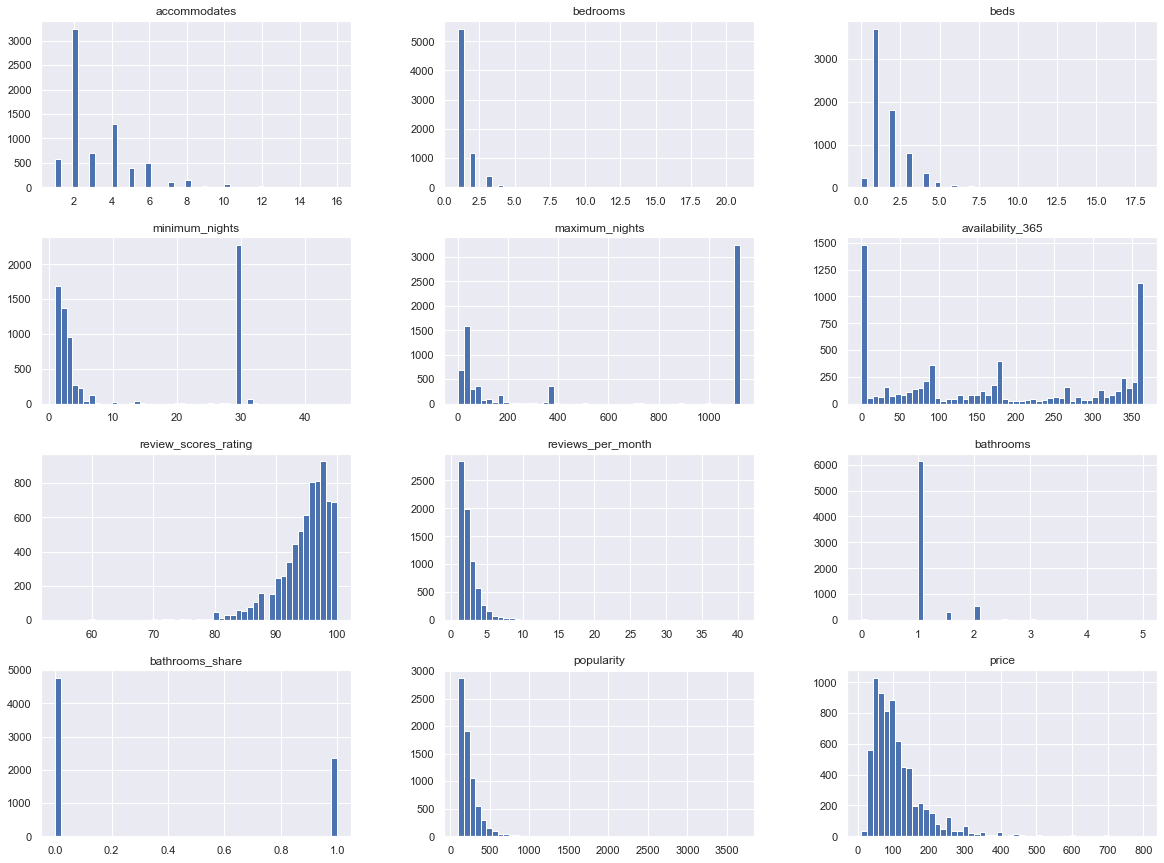

In [2472]:
try:
    new_pop.iloc[:,6:].hist(bins=50, figsize=(20,15))
    plt.show()
except AttributeError:
    pass

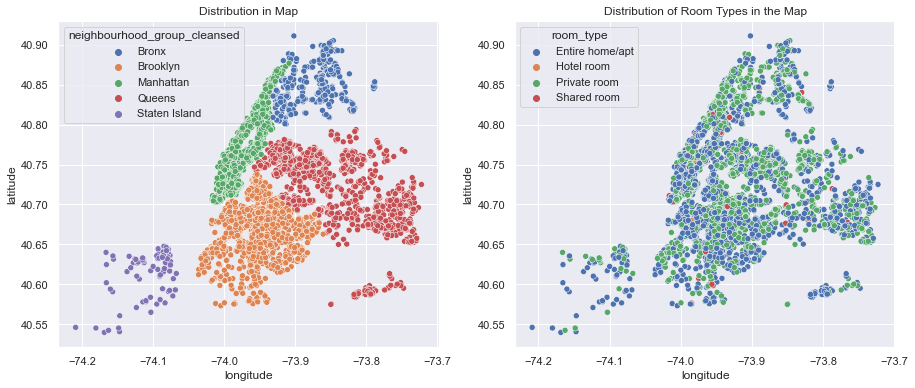

In [2473]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
sns.scatterplot(new_pop['longitude'], new_pop['latitude'], hue=new_pop['neighbourhood_group_cleansed'], ax=ax1)
ax1.set_title('Distribution in Map')

ax2 = fig.add_subplot(122)
sns.scatterplot(new_pop['longitude'],new_pop['latitude'], hue=new_pop['room_type'], ax=ax2)
ax2.set_title('Distribution of Room Types in the Map')

plt.show()

In [2475]:
'''latitudes = np.array(new_pop['latitude'])
longitudes = np.array(new_pop['longitude'])
la_mean = latitudes.mean()
lo_mean = longitudes.mean()
locations = list(zip(latitudes, longitudes))

m = folium.Map(location=[la_mean, lo_mean], zoom_start= 11.5)
FastMarkerCluster(data=locations).add_to(m)
m'''

"latitudes = np.array(new_pop['latitude'])\nlongitudes = np.array(new_pop['longitude'])\nla_mean = latitudes.mean()\nlo_mean = longitudes.mean()\nlocations = list(zip(latitudes, longitudes))\n\nm = folium.Map(location=[la_mean, lo_mean], zoom_start= 11.5)\nFastMarkerCluster(data=locations).add_to(m)\nm"

In [2476]:
new_pop.dtypes

host_is_superhost                  int64
latitude                         float64
longitude                        float64
neighbourhood_cleansed          category
neighbourhood_group_cleansed    category
room_type                       category
accommodates                       int64
bedrooms                         float64
beds                             float64
minimum_nights                     int64
maximum_nights                     int64
availability_365                   int64
review_scores_rating             float64
reviews_per_month                float64
bathrooms                        float64
bathrooms_share                    int64
popularity                       float64
price                            float64
dtype: object

In [2477]:
from sklearn.preprocessing import LabelEncoder

categorical = new_pop.select_dtypes(include=['category']).columns

for i in categorical:
  new_pop[i] = LabelEncoder().fit_transform(new_pop[i])


new_pop.dtypes

host_is_superhost                 int64
latitude                        float64
longitude                       float64
neighbourhood_cleansed            int64
neighbourhood_group_cleansed      int64
room_type                         int64
accommodates                      int64
bedrooms                        float64
beds                            float64
minimum_nights                    int64
maximum_nights                    int64
availability_365                  int64
review_scores_rating            float64
reviews_per_month               float64
bathrooms                       float64
bathrooms_share                   int64
popularity                      float64
price                           float64
dtype: object

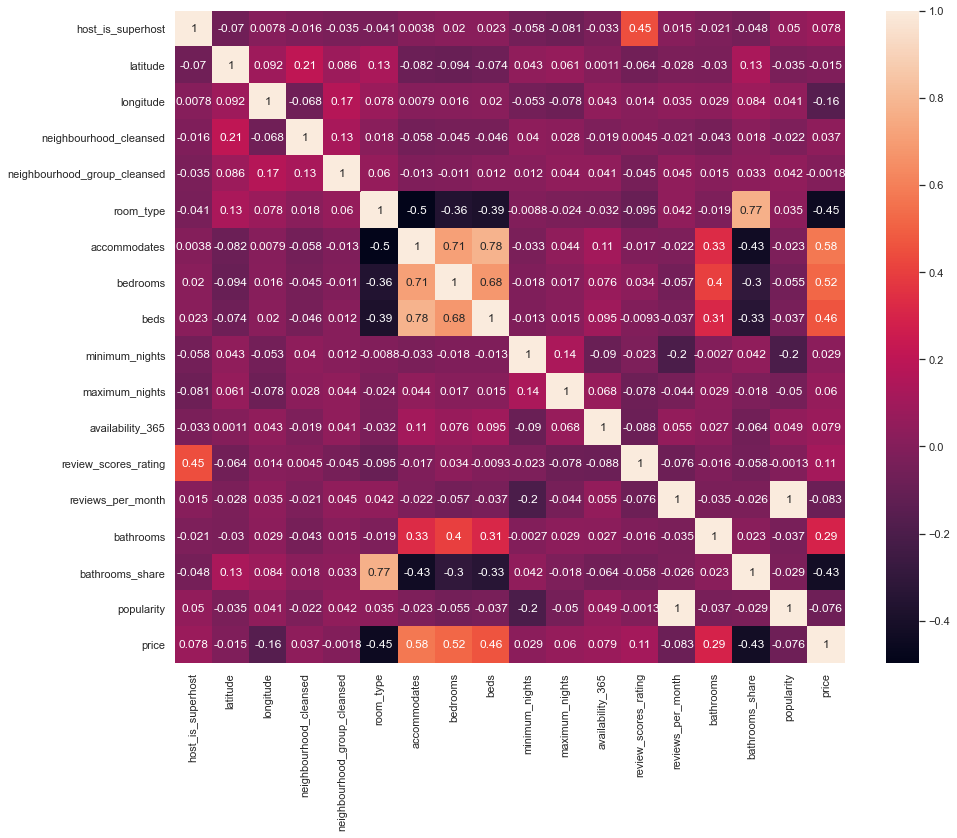

In [2478]:
correlation_mat = new_pop.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

In [2479]:
new_pop.describe()

,host_is_superhost,latitude,longitude,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,review_scores_rating,reviews_per_month,bathrooms,bathrooms_share,popularity,price
count,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000
mean,0.477895,40.724593,-73.938885,90.681825,1.711439,0.933333,3.237895,1.334175,1.775579,11.616140,565.201123,171.909754,94.865684,2.463556,1.125474,0.330807,233.094408,113.657825
std,0.499546,0.060351,0.060335,61.351387,0.868915,1.017073,2.050040,0.718658,1.253303,13.076359,521.750231,139.040534,4.624691,1.732081,0.377056,0.470537,160.350159,85.409763
min,0.000000,40.540030,-74.208820,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,54.000000,1.010000,0.000000,0.000000,100.050000,10.000000
25%,0.000000,40.682820,-73.981390,38.000000,1.000000,0.000000,2.000000,1.000000,1.000000,2.000000,30.000000,36.000000,93.000000,1.470000,1.000000,0.000000,138.180000,60.000000
50%,0.000000,40.717610,-73.947750,87.000000,2.000000,0.000000,2.000000,1.000000,1.000000,3.000000,365.000000,158.000000,96.000000,2.050000,1.000000,0.000000,195.300000,90.000000
75%,1.000000,40.761620,-73.917620,143.000000,2.000000,2.000000,4.000000,1.000000,2.000000,30.000000,1125.000000,332.000000,98.000000,2.890000,1.000000,1.000000,273.540000,139.000000
max,1.000000,40.910780,-73.722350,201.000000,4.000000,3.000000,16.000000,21.000000,18.000000,45.000000,1125.000000,365.000000,100.000000,40.310000,5.000000,1.000000,3668.210000,799.000000


In [2480]:
#from sklearn.model_selection import cross_val_score


In [2481]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = new_pop.drop(columns=['price'])
y = new_pop['price']

columns = X.columns
scaler = StandardScaler()
X[columns] = scaler.fit_transform(X[columns])



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"There are {X_train.shape[0]} traning data")
print(f"There are {X_test.shape[0]} test data")


X.head()

There are 5700 traning data
There are 1425 test data


,host_is_superhost,latitude,longitude,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,review_scores_rating,reviews_per_month,bathrooms,bathrooms_share,popularity
0,-0.956725,-0.003201,-1.144605,1.178836,0.332117,0.065552,-0.603882,-0.465032,-0.618871,-0.811914,-1.029686,-1.236487,-0.835938,21.851810,-0.332796,-0.703091,21.424093
1,-0.956725,-0.307607,-1.267925,-0.369729,0.332117,-0.917730,-0.603882,-0.465032,-0.618871,-0.735435,-0.383738,1.352868,-0.187201,21.106988,-0.332796,-0.703091,21.422035
2,-0.956725,0.566171,-0.821717,1.390745,0.332117,0.065552,-0.603882,-0.465032,-0.618871,-0.811914,1.073000,0.993235,-2.133413,18.399072,-0.332796,-0.703091,16.745503
3,-0.956725,0.358539,-0.764200,0.429005,0.332117,0.065552,-0.603882,-0.465032,-0.618871,-0.811914,-1.029686,-0.675460,-0.835938,16.372466,-0.332796,-0.703091,16.038064
4,-0.956725,0.358539,-0.764200,0.429005,0.332117,0.065552,-0.603882,-0.465032,-0.618871,-0.811914,-1.029686,-0.912818,-0.835938,12.053658,-0.332796,-0.703091,11.792806


In [2482]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor


knn = KNeighborsRegressor(5, metric="euclidean")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: {}".format(mse))
print("Mean Absolute Error: {}".format(mae))
print("Root Mean Absolute Error: {}".format(rmse))
print("R2 score: {}".format(r2))

Mean Squared Error: 3896.7598596491225
Mean Absolute Error: 36.79073684210527
Root Mean Absolute Error: 62.424032708958514
R2 score: 0.4582987900252621


In [2483]:
prediction_dictionaries = {'KNN-Default': y_pred}

In [2484]:

prediction_list = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'KNN-Default': y_pred.flatten()}).head(20)
prediction_list.set_index('Actual Values', inplace=True)
prediction_list

,KNN-Default
Actual Values,
300.0,302.0
175.0,101.2
100.0,99.0
235.0,212.2
200.0,136.4
100.0,80.0
113.0,92.4
161.0,226.2
40.0,47.2


In [2485]:
error_dict = {'KNN Default': [mse, r2]}
error_list = pd.DataFrame()
error_list['KNN Default'] = [mse, r2]
error_list.reset_index(inplace=True, drop=True)
#error_list.rename(columns={0: 'MSE KNN Default'}, inplace=True)
error_list.index =['Mean Squared Error', 'R2 Score']
error_list.T

,Mean Squared Error,R2 Score
KNN Default,3896.75986,0.458299


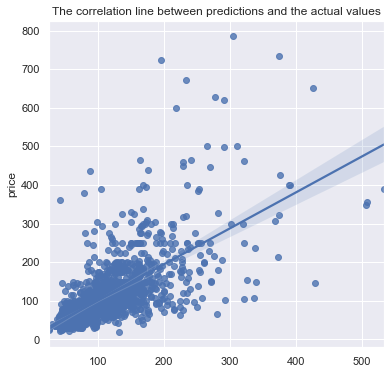

In [2486]:
plt.figure(figsize=(6,6))
sns.regplot(y_pred, y_test)
plt.title("The correlation line between predictions and the actual values")
plt.show()

In [2487]:
def plot_all_r2():
  length = len(prediction_dictionaries)
  n_col = 2
  if length < 2:
    n_col = length % 2
  
  nrow = 1
  if(length > 2):
    nrow = int(length / 2) 
    if length % 2 != 0:
      nrow+=1
  
  fig, axes = plt.subplots(nrow, n_col, figsize=( 16, 3 * length))
  for ax, key in zip(axes.flatten(), prediction_dictionaries.keys()):
    sns.regplot(prediction_dictionaries[key], y_test, ax=ax)
    ax.set_title("The correlation line in {}".format(key))
  plt.show()

In [2488]:
from sklearn.model_selection import GridSearchCV
param_grid = {'p': [1, 2],  
              'n_neighbors' : [ 5, 10, 15]
              } 

grid_knn = GridSearchCV(KNeighborsRegressor(n_jobs=-1), param_grid, refit = True, verbose = 10, n_jobs=-1, cv=5,scoring="neg_mean_squared_error") 

grid_knn.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    1.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    2.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished


GridSearchCV(cv=5, estimator=KNeighborsRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15], 'p': [1, 2]},
             scoring='neg_mean_squared_error', verbose=10)

In [2489]:

print(f"Best parameters are {grid_knn.best_params_}") 
print("Best score is {}".format(grid_knn.best_score_ * -1))
print("Best model is {}".format(grid_knn.best_estimator_))
#print("The score for hyperparameter tuning are {}".format(gr

Best parameters are {'n_neighbors': 15, 'p': 1}
Best score is 3583.9288645614033
Best model is KNeighborsRegressor(n_jobs=-1, n_neighbors=15, p=1)


In [2490]:
knr_best = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=15, p=1,
                    weights='uniform')
knr_best.fit(X_train, y_train)
y_pred_best = knr_best.predict(X_test)

mse_knn_best = mean_squared_error(y_pred_best, y_test)
mae_knn_best = mean_absolute_error(y_pred, y_test)
rmse_knn_best = np.sqrt(mse)
r2_knn_best = r2_score(y_test, y_pred_best)

print("Mean Squared Error: {}".format(mse_knn_best))
print("Mean Absolute Error: {}".format(mae_knn_best))
print("Root Mean Absolute Error: {}".format(rmse_knn_best))
print("R2 score: {}".format(r2_knn_best))

Mean Squared Error: 3244.156871734893
Mean Absolute Error: 36.79073684210527
Root Mean Absolute Error: 62.424032708958514
R2 score: 0.5490192452031439


In [2491]:
prediction_dictionaries['Knn-Best']   = y_pred_best

In [2492]:
prediction_list['KNN-Best'] = y_pred_best[:20]
prediction_list

,KNN-Default,KNN-Best
Actual Values,,
300.0,302.0,207.133333
175.0,101.2,105.733333
100.0,99.0,102.666667
235.0,212.2,230.600000
200.0,136.4,161.000000
100.0,80.0,81.333333
113.0,92.4,98.466667
161.0,226.2,171.466667
40.0,47.2,50.466667


In [2493]:
error_list['MSE KNN-Best'] = [mse_knn_best, r2_knn_best]
error_list.T

,Mean Squared Error,R2 Score
KNN Default,3896.759860,0.458299
MSE KNN-Best,3244.156872,0.549019


In [2494]:
from sklearn.svm import LinearSVR, SVR
clf_svr = LinearSVR()
clf_svr.fit(X_train, y_train)

preds_svr = clf_svr.predict(X_test)

mse_svr = mean_squared_error(preds_svr, y_test)
mae_svr = mean_absolute_error(preds_svr, y_test)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, preds_svr)

print("Mean Squared Error: {}".format(mse_svr))
print("Mean Absolute Error: {}".format(mae_svr))
print("Root Mean Absolute Error: {}".format(rmse_svr))
print("R2 Score: {}".format(r2_svr))

Mean Squared Error: 4154.089708529882
Mean Absolute Error: 36.384929772169755
Root Mean Absolute Error: 64.45222811144609
R2 Score: 0.42252653422249475


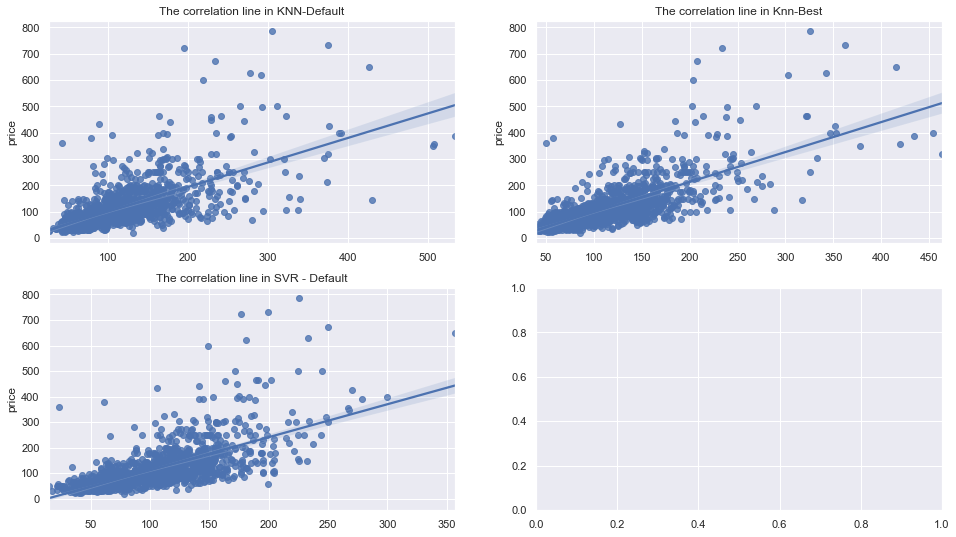

In [2495]:
prediction_dictionaries['SVR - Default'] = preds_svr
plot_all_r2()

In [2496]:
prediction_list['SVR-Default'] = np.array(preds_svr[:20])
prediction_list

,KNN-Default,KNN-Best,SVR-Default
Actual Values,,,
300.0,302.0,207.133333,137.706638
175.0,101.2,105.733333,99.509904
100.0,99.0,102.666667,121.803627
235.0,212.2,230.600000,204.086472
200.0,136.4,161.000000,148.317483
100.0,80.0,81.333333,70.241874
113.0,92.4,98.466667,116.457188
161.0,226.2,171.466667,114.509774
40.0,47.2,50.466667,60.501733


In [2497]:
error_list['SVR Default'] = [mse_svr, r2_svr]
error_list.T

,Mean Squared Error,R2 Score
KNN Default,3896.759860,0.458299
MSE KNN-Best,3244.156872,0.549019
SVR Default,4154.089709,0.422527


In [2498]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 
              'dual': [True, False],
              'tol': [0.0001, 0.00001]} 

grid = GridSearchCV(LinearSVR(), param_grid, refit = True, verbose = 10, n_jobs=-1, cv=5,scoring="neg_mean_squared_error") 

grid.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0261s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1938s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0885s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.4s finished


GridSearchCV(cv=5, estimator=LinearSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'dual': [True, False],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'tol': [0.0001, 1e-05]},
             scoring='neg_mean_squared_error', verbose=10)

In [2499]:
print(f"Best parameters are {grid.best_params_}") 
print("Best score is {}".format(grid.best_score_ * -1))
print("Best model is {}".format(grid.best_estimator_))
print("scores {}".format(grid.cv_results_['mean_test_score']))

Best parameters are {'C': 1, 'dual': True, 'loss': 'squared_epsilon_insensitive', 'tol': 0.0001}
Best score is 4128.128695651688
Best model is LinearSVR(C=1, loss='squared_epsilon_insensitive')
scores [-5381.04877098 -5381.15771699 -4153.41080878 -4153.72379159
            nan            nan -4153.7027139  -4153.69249262
 -4547.40189678 -4556.20172801 -4128.12869565 -4129.22547368
            nan            nan -4140.83177408 -4140.93365203
 -4457.30997813 -4455.12044904 -4131.0141759  -4196.8597271
            nan            nan -4138.58827881 -4138.65957139
 -4432.66580845 -4456.46343227 -6168.66565591 -6053.2818124
            nan            nan -4138.39508705 -4138.46870034
 -4593.51027341 -4483.79704621 -7735.45336169 -6749.77819658
            nan            nan -4138.37679409 -4138.45063187]


In [2500]:
svr_best = LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

svr_best.fit(X_train, y_train)

preds_svr_best = svr_best.predict(X_test)

mse_svr_best = mean_squared_error(preds_svr_best, y_test)
mae_svr_best = mean_absolute_error(preds_svr_best, y_test)
rmse_svr_best = np.sqrt(mse_svr_best)
r2_svr_best = r2_score(y_test, preds_svr_best)

print("Mean Squared Error: {}".format(mse_svr_best))
print("Mean Absolute Error: {}".format(mae_svr_best))
print("Root Mean Absolute Error: {}".format(rmse_svr_best))
print("R2 Score: {}".format(r2_svr_best))

Mean Squared Error: 4154.67943996031
Mean Absolute Error: 36.38995648672212
Root Mean Absolute Error: 64.45680289899826
R2 Score: 0.4224445537461685


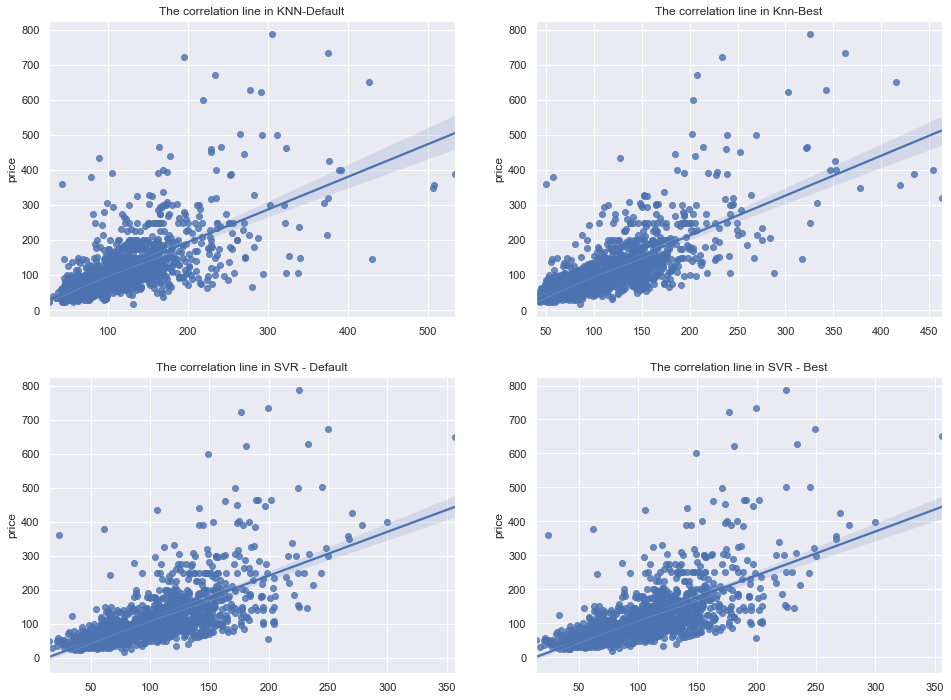

In [2501]:
prediction_dictionaries['SVR - Best'] = preds_svr_best
plot_all_r2()

In [2502]:
prediction_list['SVR-Best'] = np.array(preds_svr_best[:20])
prediction_list

,KNN-Default,KNN-Best,SVR-Default,SVR-Best
Actual Values,,,,
300.0,302.0,207.133333,137.706638,137.609376
175.0,101.2,105.733333,99.509904,99.864486
100.0,99.0,102.666667,121.803627,121.745310
235.0,212.2,230.600000,204.086472,203.492427
200.0,136.4,161.000000,148.317483,148.610625
100.0,80.0,81.333333,70.241874,70.519247
113.0,92.4,98.466667,116.457188,116.109593
161.0,226.2,171.466667,114.509774,114.518907
40.0,47.2,50.466667,60.501733,60.497384


In [2503]:
error_list['SVR Best'] = [mse_svr_best, r2_svr_best]
error_list.T

,Mean Squared Error,R2 Score
KNN Default,3896.759860,0.458299
MSE KNN-Best,3244.156872,0.549019
SVR Default,4154.089709,0.422527
SVR Best,4154.679440,0.422445


In [2504]:
parameters = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
}
tree_grid = GridSearchCV(tree_model, parameters, refit = True, verbose = 1, n_jobs=-1, cv=5, scoring="neg_mean_squared_error") 
tree_grid.fit(X, y)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    3.5s finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='neg_mean_squared_error', verbose=1)

In [2505]:
tree_model_best = tree.DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 4, min_samples_split = 4)
tree_model_best.fit(X_train, y_train) 
tree_model_prediction_best = tree_model_best.predict(X_test)

tree_mse_best = metrics.mean_squared_error(y_test, tree_model_prediction_best)
tree_mae_best = metrics.mean_absolute_error(y_test, tree_model_prediction_best)
tree_rmse_best = np.sqrt(tree_mse_best)
tree_r2_best = metrics.r2_score(y_test, tree_model_prediction_best)

print("Mean Squared Error: {}".format(tree_mse_best))
print("Mean Absolute Error: {}".format(tree_mae_best))
print("Root Mean Absolute Error: {}".format(tree_rmse_best))
print("R2 score: {}".format(tree_r2_best))

Mean Squared Error: 3544.9499103958983
Mean Absolute Error: 35.67893580204273
Root Mean Absolute Error: 59.53948194598185
R2 score: 0.507205030608633


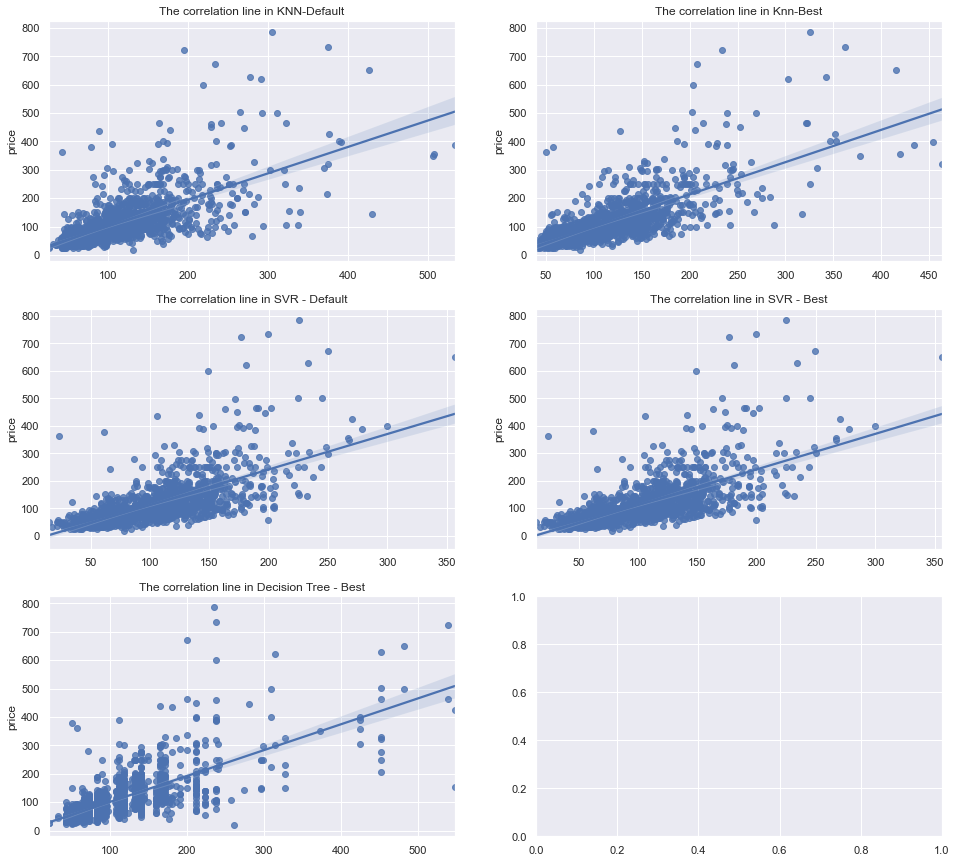

In [2506]:
prediction_dictionaries['Decision Tree - Best'] = tree_model_prediction_best
plot_all_r2()

In [2507]:
prediction_list['Decision Tree - Best'] = np.array(preds_svr_best[:20])
prediction_list

,KNN-Default,KNN-Best,SVR-Default,SVR-Best,Decision Tree - Best
Actual Values,,,,,
300.0,302.0,207.133333,137.706638,137.609376,137.609376
175.0,101.2,105.733333,99.509904,99.864486,99.864486
100.0,99.0,102.666667,121.803627,121.745310,121.745310
235.0,212.2,230.600000,204.086472,203.492427,203.492427
200.0,136.4,161.000000,148.317483,148.610625,148.610625
100.0,80.0,81.333333,70.241874,70.519247,70.519247
113.0,92.4,98.466667,116.457188,116.109593,116.109593
161.0,226.2,171.466667,114.509774,114.518907,114.518907
40.0,47.2,50.466667,60.501733,60.497384,60.497384


In [2508]:
error_list['Decision Tree - Best'] = [tree_mse_best, tree_r2_best]
error_list.T

,Mean Squared Error,R2 Score
KNN Default,3896.759860,0.458299
MSE KNN-Best,3244.156872,0.549019
SVR Default,4154.089709,0.422527
SVR Best,4154.679440,0.422445
Decision Tree - Best,3544.949910,0.507205


In [2509]:
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor() #n_estimators is 100 by default
forest_model.fit(X_train, y_train)
forest_model_prediction = forest_model.predict(X_test)

forest_mse = metrics.mean_squared_error(y_test, forest_model_prediction)
forest_mae = metrics.mean_absolute_error(y_test, forest_model_prediction)
forest_rmse = np.sqrt(forest_mse)
forest_r2 = metrics.r2_score(y_test, forest_model_prediction)

print("Mean Squared Error: {}".format(forest_mse))
print("Mean Absolute Error: {}".format(forest_mae))
print("Root Mean Absolute Error: {}".format(forest_rmse))
print("R2 score: {}".format(forest_r2))

Mean Squared Error: 2858.807279649123
Mean Absolute Error: 32.48331929824561
Root Mean Absolute Error: 53.467815362600355
R2 score: 0.6025879401739778


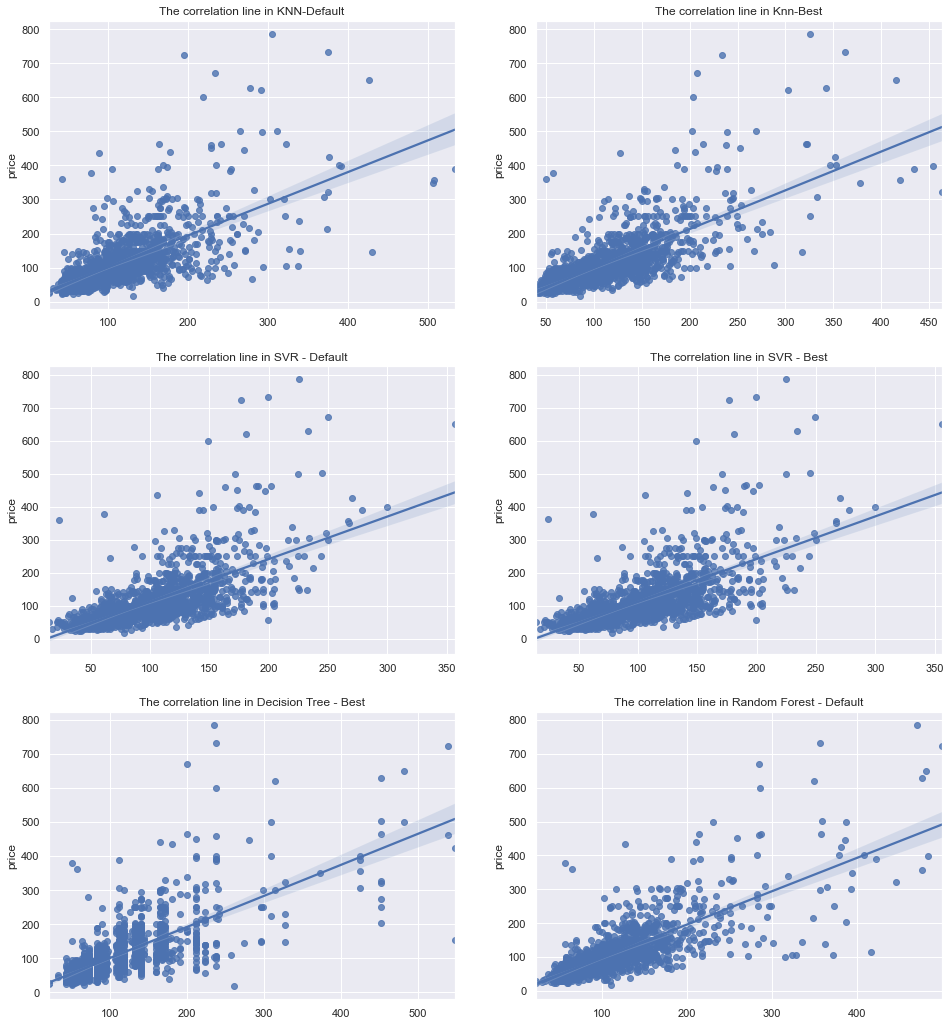

In [2510]:
prediction_dictionaries['Random Forest - Default'] = forest_model_prediction
plot_all_r2()

In [2511]:
prediction_list['Random Forest - Default'] = np.array(preds_svr[:20])
prediction_list

,KNN-Default,KNN-Best,SVR-Default,SVR-Best,Decision Tree - Best,Random Forest - Default
Actual Values,,,,,,
300.0,302.0,207.133333,137.706638,137.609376,137.609376,137.706638
175.0,101.2,105.733333,99.509904,99.864486,99.864486,99.509904
100.0,99.0,102.666667,121.803627,121.745310,121.745310,121.803627
235.0,212.2,230.600000,204.086472,203.492427,203.492427,204.086472
200.0,136.4,161.000000,148.317483,148.610625,148.610625,148.317483
100.0,80.0,81.333333,70.241874,70.519247,70.519247,70.241874
113.0,92.4,98.466667,116.457188,116.109593,116.109593,116.457188
161.0,226.2,171.466667,114.509774,114.518907,114.518907,114.509774
40.0,47.2,50.466667,60.501733,60.497384,60.497384,60.501733


In [2512]:
error_list['Random Forest - Default'] = [forest_mse, forest_r2]
error_list.T

,Mean Squared Error,R2 Score
KNN Default,3896.759860,0.458299
MSE KNN-Best,3244.156872,0.549019
SVR Default,4154.089709,0.422527
SVR Best,4154.679440,0.422445
Decision Tree - Best,3544.949910,0.507205
Random Forest - Default,2858.807280,0.602588


In [2513]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


linear_model = LinearRegression().fit(X_train, y_train)
linear_model_prediction = linear_model.predict(X_test)

linear_mse = metrics.mean_squared_error(y_test, linear_model_prediction)
linear_mae = metrics.mean_absolute_error(y_test, linear_model_prediction)
linear_rmse = np.sqrt(linear_mse)
linear_r2 = metrics.r2_score(y_test, linear_model_prediction)

print("Mean Squared Error: {}".format(linear_mse))
print("Mean Absolute Error: {}".format(linear_mae))
print("Root Mean Absolute Error: {}".format(linear_rmse))
print("R2 score: {}".format(linear_r2))

Mean Squared Error: 3740.109134522172
Mean Absolute Error: 38.706339828681045
Root Mean Absolute Error: 61.156431669303366
R2 score: 0.4800753147281033


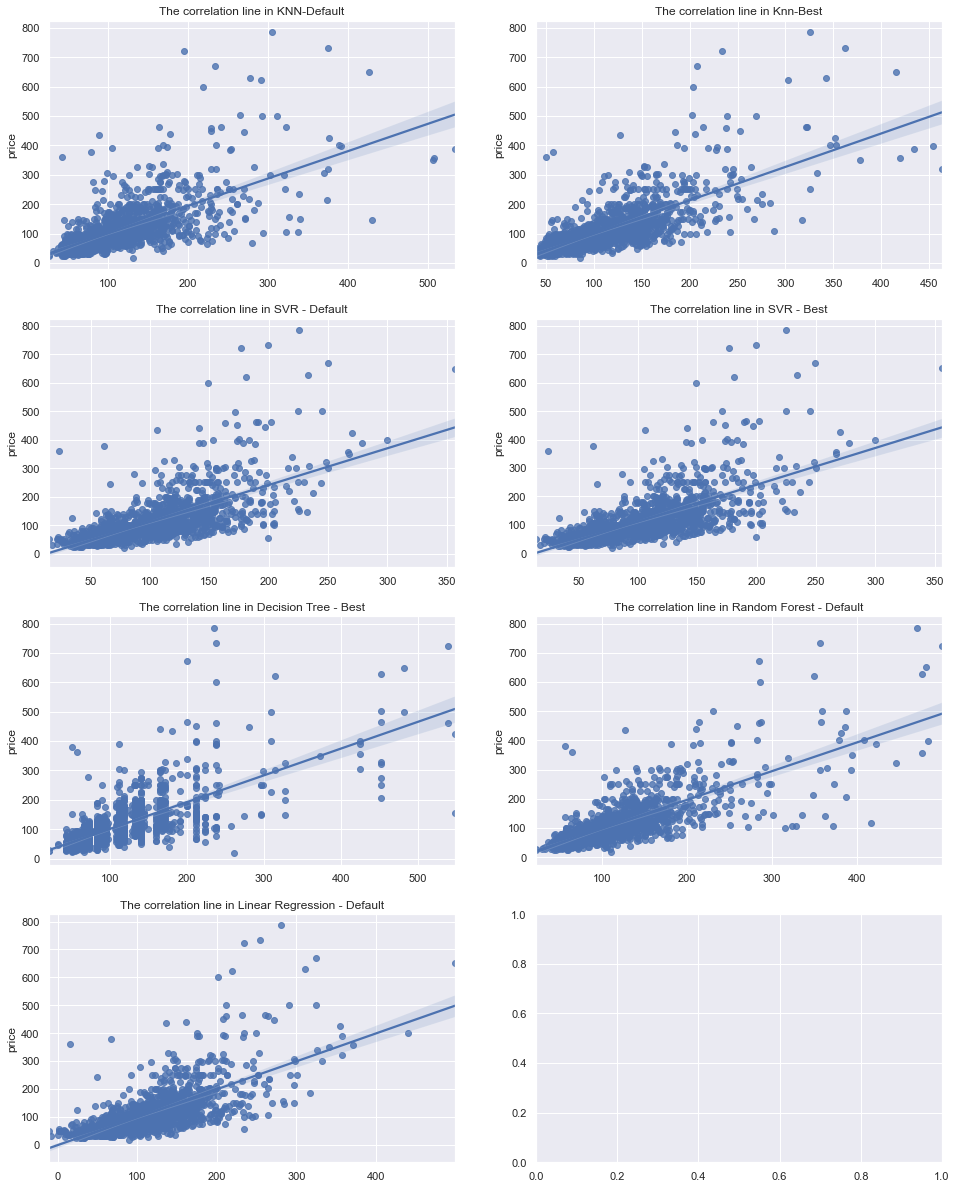

In [2514]:
prediction_dictionaries['Linear Regression - Default'] = linear_model_prediction
plot_all_r2()

In [2515]:
prediction_list['Linear Regression - Default'] = np.array(preds_svr[:20])
prediction_list

,KNN-Default,KNN-Best,SVR-Default,SVR-Best,Decision Tree - Best,Random Forest - Default,Linear Regression - Default
Actual Values,,,,,,,
300.0,302.0,207.133333,137.706638,137.609376,137.609376,137.706638,137.706638
175.0,101.2,105.733333,99.509904,99.864486,99.864486,99.509904,99.509904
100.0,99.0,102.666667,121.803627,121.745310,121.745310,121.803627,121.803627
235.0,212.2,230.600000,204.086472,203.492427,203.492427,204.086472,204.086472
200.0,136.4,161.000000,148.317483,148.610625,148.610625,148.317483,148.317483
100.0,80.0,81.333333,70.241874,70.519247,70.519247,70.241874,70.241874
113.0,92.4,98.466667,116.457188,116.109593,116.109593,116.457188,116.457188
161.0,226.2,171.466667,114.509774,114.518907,114.518907,114.509774,114.509774
40.0,47.2,50.466667,60.501733,60.497384,60.497384,60.501733,60.501733


In [2516]:
error_list['Linear Regression - Default'] = [linear_mse, linear_r2]
error_list.T

,Mean Squared Error,R2 Score
KNN Default,3896.759860,0.458299
MSE KNN-Best,3244.156872,0.549019
SVR Default,4154.089709,0.422527
SVR Best,4154.679440,0.422445
Decision Tree - Best,3544.949910,0.507205
Random Forest - Default,2858.807280,0.602588
Linear Regression - Default,3740.109135,0.480075


In [2517]:
from sklearn.linear_model import Ridge

alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 250, 500, 750, 1000, 1500, 2500, 5000, 10000, 100000, 1000000]
param_grid = {
    'alpha': alpha
}

ridge = Ridge(alpha=1).fit(X_train, y_train)
scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring='r2')
scores_mse = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print("CV Mean for Ridge (r2): ", np.mean(scores))
print("CV Mean for Ridge (mse): ", np.mean(scores_mse) * -1)

CV Mean for Ridge (r2):  0.44800652611956326
CV Mean for Ridge (mse):  4052.6570823127417


In [2518]:
grid_mse = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_result_mse = grid_mse.fit(X_train, y_train)

grid_r2 = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result_r2 = grid_r2.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.2s finished


In [2519]:
print('Best Score for mse: ', grid_mse.best_score_ * -1)
print('Best Params for mse: ', grid_mse.best_params_)
print()
print('Best Score for r2: ', grid_r2.best_score_)
print('Best Params for r2: ', grid_r2.best_params_)

Best Score for mse:  4042.5695058167635
Best Params for mse:  {'alpha': 250}

Best Score for r2:  0.44965138883816413
Best Params for r2:  {'alpha': 250}


In [2520]:
ridge_best = Ridge(alpha=500).fit(X_train, y_train)
ridge_best.fit(X_train, y_train)
ridge_pred = ridge_best.predict(X_test)

ridge_mse_best = metrics.mean_squared_error(y_test, ridge_pred)
ridge_mae_best = metrics.mean_absolute_error(y_test, ridge_pred)
ridge_rmse_best = np.sqrt(ridge_mse_best)
ridge_r2_best = metrics.r2_score(y_test, ridge_pred)

print("Mean Squared Error: {}".format(ridge_mse_best))
print("Mean Absolute Error: {}".format(ridge_mae_best))
print("Root Mean Absolute Error: {}".format(ridge_rmse_best))
print("R2 score: {}".format(ridge_r2_best))

Mean Squared Error: 3738.1595150977805
Mean Absolute Error: 38.348607529065255
Root Mean Absolute Error: 61.14048998084478
R2 score: 0.48034633763924517


In [2521]:
dict_val = {
    'Linear Model': [linear_r2, linear_mse],
    'Ridge': [ridge_r2_best, ridge_mse_best]
}
res_df_linear_ridge = pd.DataFrame(dict_val, index=['R2', 'MSE'])
res_df_linear_ridge

,Linear Model,Ridge
R2,0.480075,0.480346
MSE,3740.109135,3738.159515


In [2522]:
prediction_dictionaries['Ridge'] = ridge_pred

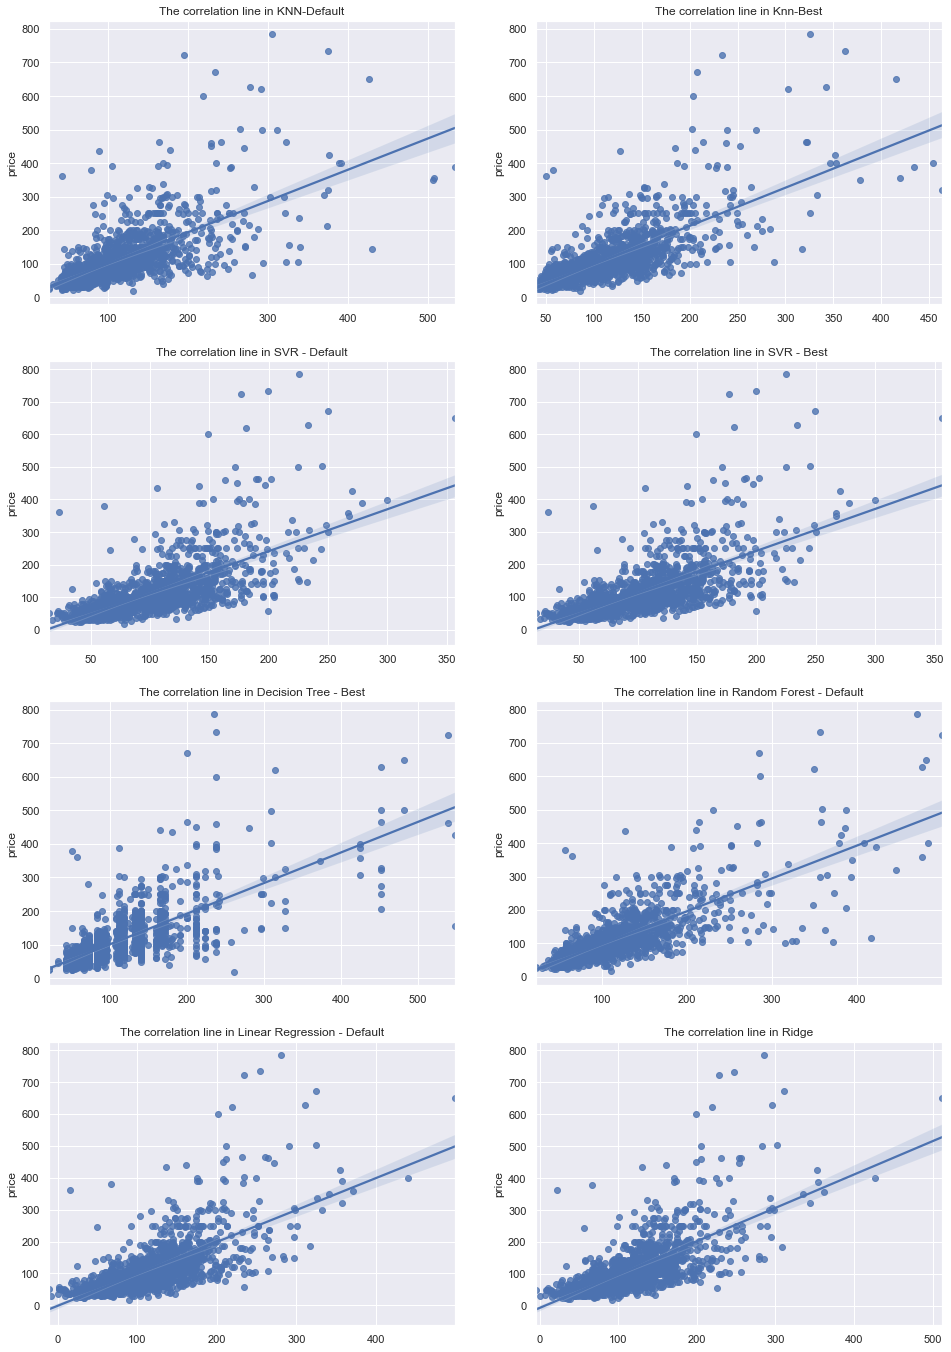

In [2523]:
plot_all_r2()

In [2524]:
prediction_list['Ridge'] = np.array(preds_svr[:20])
prediction_list

,KNN-Default,KNN-Best,SVR-Default,SVR-Best,Decision Tree - Best,Random Forest - Default,Linear Regression - Default,Ridge
Actual Values,,,,,,,,
300.0,302.0,207.133333,137.706638,137.609376,137.609376,137.706638,137.706638,137.706638
175.0,101.2,105.733333,99.509904,99.864486,99.864486,99.509904,99.509904,99.509904
100.0,99.0,102.666667,121.803627,121.745310,121.745310,121.803627,121.803627,121.803627
235.0,212.2,230.600000,204.086472,203.492427,203.492427,204.086472,204.086472,204.086472
200.0,136.4,161.000000,148.317483,148.610625,148.610625,148.317483,148.317483,148.317483
100.0,80.0,81.333333,70.241874,70.519247,70.519247,70.241874,70.241874,70.241874
113.0,92.4,98.466667,116.457188,116.109593,116.109593,116.457188,116.457188,116.457188
161.0,226.2,171.466667,114.509774,114.518907,114.518907,114.509774,114.509774,114.509774
40.0,47.2,50.466667,60.501733,60.497384,60.497384,60.501733,60.501733,60.501733


In [2525]:
error_list['Ridge'] = [ridge_mse_best, ridge_r2_best]
error_list.T

,Mean Squared Error,R2 Score
KNN Default,3896.759860,0.458299
MSE KNN-Best,3244.156872,0.549019
SVR Default,4154.089709,0.422527
SVR Best,4154.679440,0.422445
Decision Tree - Best,3544.949910,0.507205
Random Forest - Default,2858.807280,0.602588
Linear Regression - Default,3740.109135,0.480075
Ridge,3738.159515,0.480346


In [2526]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score


elastic_net = ElasticNet(random_state=42).fit(X_train, y_train)
elastic_net_prediction = elastic_net.predict(X_test)

elastic_net_mse = metrics.mean_squared_error(y_test, elastic_net_prediction)
elastic_net_mae = metrics.mean_absolute_error(y_test, elastic_net_prediction)
elastic_net_rmse = np.sqrt(elastic_net_mse)
elastic_net_r2 = metrics.r2_score(y_test, elastic_net_prediction)

print("Mean Squared Error: {}".format(elastic_net_mse))
print("Mean Absolute Error: {}".format(elastic_net_mae))
print("Root Mean Absolute Error: {}".format(elastic_net_rmse))
print("R2 score: {}".format(elastic_net_r2))

Mean Squared Error: 3884.6467456007554
Mean Absolute Error: 38.37372028554076
Root Mean Absolute Error: 62.326934351055286
R2 score: 0.4599826732443715


In [2527]:
prediction_list['ElasticNet'] = np.array(preds_svr[:20])
prediction_list

,KNN-Default,KNN-Best,SVR-Default,SVR-Best,Decision Tree - Best,Random Forest - Default,Linear Regression - Default,Ridge,ElasticNet
Actual Values,,,,,,,,,
300.0,302.0,207.133333,137.706638,137.609376,137.609376,137.706638,137.706638,137.706638,137.706638
175.0,101.2,105.733333,99.509904,99.864486,99.864486,99.509904,99.509904,99.509904,99.509904
100.0,99.0,102.666667,121.803627,121.745310,121.745310,121.803627,121.803627,121.803627,121.803627
235.0,212.2,230.600000,204.086472,203.492427,203.492427,204.086472,204.086472,204.086472,204.086472
200.0,136.4,161.000000,148.317483,148.610625,148.610625,148.317483,148.317483,148.317483,148.317483
100.0,80.0,81.333333,70.241874,70.519247,70.519247,70.241874,70.241874,70.241874,70.241874
113.0,92.4,98.466667,116.457188,116.109593,116.109593,116.457188,116.457188,116.457188,116.457188
161.0,226.2,171.466667,114.509774,114.518907,114.518907,114.509774,114.509774,114.509774,114.509774
40.0,47.2,50.466667,60.501733,60.497384,60.497384,60.501733,60.501733,60.501733,60.501733


In [2528]:
error_list['ElasticNet'] = [ridge_mse_best, ridge_r2_best]
error_list.T

,Mean Squared Error,R2 Score
KNN Default,3896.759860,0.458299
MSE KNN-Best,3244.156872,0.549019
SVR Default,4154.089709,0.422527
SVR Best,4154.679440,0.422445
Decision Tree - Best,3544.949910,0.507205
Random Forest - Default,2858.807280,0.602588
Linear Regression - Default,3740.109135,0.480075
Ridge,3738.159515,0.480346
ElasticNet,3738.159515,0.480346


In [ ]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
sns.scatterplot(new_pop['longitude'], new_pop['latitude'], hue=new_pop['neighbourhood_group_cleansed'], ax=ax1)
ax1.set_title('Distribution in Map')

ax2 = fig.add_subplot(122)
sns.scatterplot(new_pop['longitude'],new_pop['latitude'], hue=new_pop['room_type'], ax=ax2)
ax2.set_title('Distribution of Room Types in the Map')

plt.show()

In [ ]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
sns.scatterplot(new_pop['longitude'], new_pop['latitude'], hue=new_pop['neighbourhood_group_cleansed'], ax=ax1)
ax1.set_title('Distribution in Map')

ax2 = fig.add_subplot(122)
sns.scatterplot(new_pop['longitude'],new_pop['latitude'], hue=new_pop['room_type'], ax=ax2)
ax2.set_title('Distribution of Room Types in the Map')

plt.show()

In [ ]:
latitudes = np.array(new_pop['latitude'])
longitudes = np.array(new_pop['longitude'])
la_mean = latitudes.mean()
lo_mean = longitudes.mean()
locations = list(zip(latitudes, longitudes))

m = folium.Map(location=[la_mean, lo_mean], zoom_start= 11.5)
FastMarkerCluster(data=locations).add_to(m)
m